<div>
This notebook analyzes the publications of 10 countries in 4 databases. The analysis is restricted to the publications with DOIs for
Turkey, Iran, Egypt, Saudi Arabia, Malaysia, Pakistan, Nigeria, Indonesia, Tunisia, Bangladesh
</div>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

In [ ]:
#SQL script
#THE 1ST BLOCK OF THE SCRIPT PRODUCES TABLES WITH COUNTS OF PUBLICATIONS FOR INDIVIDUAL COUNTRIES IN THE 4 DATABASES. 
#THE 2ND BLOCK PRODUCES COUNTS OF PUBLICATIONS THAT are UNIQUE PER DATABASE AND/OR ARE COMMON AMONG DATABASE PAIRS, 
#TRIADS AND QUADS

#1ST BLOCK
drop table #scopus_dataset
select distinct a.eid, a.pub_year, a.doi, b.country_iso_alpha3_code, c.country
, c.country_iso_alpha2_code --I have added this
into #scopus_dataset
from scopus_2022apr.dbo.pub as a
join scopus_2022apr.dbo.pub_affiliation as b on a.eid=b.eid
join scopus_2022apr.dbo.country as c on b.country_iso_alpha3_code=c.country_iso_alpha3_code
where b.country_iso_alpha3_code IN ('EGY', 'IDN', 'IRN', 'MYS', 'PAK', 'SAU', 'TUR', 'BGD', 'NGA', 'TUN')

--------------------------------------------------------------------------------------------------------------------------------
drop table #dimensions_dataset
select distinct a.pub_id, a.pub_year, a.doi, b.country_code, c.country
into #dimensions_dataset
from dimensions_2022jun.dbo.pub as a 
join dimensions_2022jun.dbo.pub_affiliation_country as b on a.pub_id=b.pub_id
join dimensions_2022jun.dbo.country as c on b.country_code=c.country_code
where b.country_code IN ('EG','ID','IR','MY','PK','SA', 'TR', 'BD', 'TN', 'NG')

--------------------------------------------------------------------------------------------------------------------------------
DROP TABLE #WOS_DATASET
SELECT DISTINCT A.ut, A.pub_year, A.doi, B.country_id, C.country
, c.country_iso_alpha2_code --I have added this
INTO #WOS_DATASET
FROM wos_2213.dbo.pub AS A
JOIN wos_2213.dbo.pub_affiliation AS B ON (A.ut=B.ut)
JOIN wos_2213.dbo.country AS C ON (B.country_id = C.country_id)
WHERE B.country_id IN (62,96,97,125,157,178,214,18,151,213)

----------------------------------------------------------------------------------------------------------------------
DROP TABLE #ALEX_DATASET
SELECT DISTINCT W.work_id, W.pub_year, W.doi, C.country
, inst.country_iso_alpha2_code --I have added this
INTO #ALEX_DATASET
FROM [openalex_2022oct].dbo.work AS W
JOIN [openalex_2022oct].dbo.work_institution AS WINST ON (W.work_id = WINST.work_id)
JOIN [openalex_2022oct].dbo.institution AS INST ON (WINST.institution_id = INST.institution_id)
JOIN [openalex_2022oct].dbo.country AS C ON (INST.country_iso_alpha2_code = C.country_iso_alpha2_code)
WHERE W.work_type_id IN (1, 2, 3, 4, 5, 8, 11, 14, 19, 21, 23, 24) AND INST.country_iso_alpha2_code IN 
('EG','ID','IR','MY','PK','SA', 'TR', 'BD', 'TN', 'NG')

--------------------------------------------------------------------------------------------------------------------------------
drop table #scopus_summary
select country, count(DISTINCT eid) as p_scopus, count(DISTINCT doi) as p_doi_scopus
into #scopus_summary
from #scopus_dataset
where pub_year between 1980 and 2020
group by country

drop table #dimensions_summary
select country, count(DISTINCT pub_id) as p_dimensions, count(DISTINCT doi) as p_doi_dimensions
into #dimensions_summary
from #dimensions_dataset
where pub_year between 1980 and 2020
group by country

drop table #wos_summary
select country, count(DISTINCT ut) as p_wos, count(DISTINCT doi) as p_doi_wos
into #wos_summary
from #WOS_DATASET
where pub_year between 1980 and 2020
group by country


DROP TABLE #ALEX_SUMMARY
SELECT country, COUNT(DISTINCT work_id) AS P_ALEX, COUNT(DISTINCT doi) AS P_DOI_ALEX
INTO #ALEX_SUMMARY
FROM #ALEX_DATASET
where pub_year between 1980 and 2020
GROUP BY country

---------------------------------------------------------------------------------------------------------------------
select a.*, b.p_scopus, b.p_doi_scopus, c.p_wos, c.p_doi_wos, d.P_ALEX, d.P_DOI_ALEX
from #dimensions_summary as a
left join #scopus_summary as b on (a.country=b.country)
left join #wos_summary as c on (a.country=c.country)
left join #ALEX_SUMMARY as d on (a.country = d.country)
order by a.country


#2ND BLOCK
drop table #total_dataset
select *
into #total_dataset
from 
	(select distinct doi, country_iso_alpha2_code, pub_year, 'scopus' as database_
     from #scopus_dataset
	 where doi is not null
	 UNION
	 select distinct doi, country_code, pub_year, 'dimensions' as database_
     from #dimensions_dataset
	 where doi is not null
	 UNION
	 select distinct doi, country_iso_alpha2_code, pub_year, 'wos' as database_
     from #wos_dataset
	 where doi is not null
	 UNION
	 select distinct doi, country_iso_alpha2_code, pub_year, 'openalex' as database_
     from #alex_dataset
	 where doi is not null 
	 ) as total


 drop table #total_database_pivot
 select *
 into #total_database_pivot
 from #total_dataset as table_
 PIVOT (count(database_) for database_ in ([scopus],[dimensions],[wos],[openalex])) as pvt
 order by country_iso_alpha2_code, pub_year

 -- All countries
  select upper(country_iso_alpha2_code) as country_code, [scopus], [dimensions],[wos], [openalex], count(doi) as pubs
 from #total_database_pivot
 where pub_year between 1980 and 2020
 group by upper(country_iso_alpha2_code), [scopus], [dimensions], [wos], [openalex]
 order by upper(country_iso_alpha2_code), [scopus], [dimensions], [wos], [openalex]
 

In [ ]:
#SQL script
#The SCRIPT retrieves all publications from every country where there is a doi associated with publications
#CTE_1 to CTE_4 retrieve publications from every database for the intended countries

WITH CTE_1 AS (
select distinct a.eid, a.pub_year, a.doi, b.country_iso_alpha3_code, c.country
from scopus_2022apr.dbo.pub as a
inner join scopus_2022apr.dbo.pub_affiliation as b on a.eid=b.eid
inner join scopus_2022apr.dbo.country as c on b.country_iso_alpha3_code=c.country_iso_alpha3_code
where b.country_iso_alpha3_code IN ('EGY', 'IDN', 'IRN', 'MYS', 'PAK', 'SAU', 'TUR', 'BGD', 'NGA', 'TUN') 
AND a.pub_year between 1980 and 2020
)

, CTE_2 AS (
select distinct a.pub_id, a.pub_year, a.doi, b.country_code, c.country
from dimensions_2022jun.dbo.pub as a 
inner join dimensions_2022jun.dbo.pub_affiliation_country as b on a.pub_id=b.pub_id
inner join dimensions_2022jun.dbo.country as c on b.country_code=c.country_code
where b.country_code IN ('EG','ID','IR','MY','PK','SA', 'TR', 'BD', 'TN', 'NG')
AND a.pub_year between 1980 and 2020
)

, CTE_3 AS (
SELECT DISTINCT A.ut, A.pub_year, A.doi, B.country_id, C.country
FROM wos_2213.dbo.pub AS A
INNER JOIN wos_2213.dbo.pub_affiliation AS B ON (A.ut=B.ut)
INNER JOIN wos_2213.dbo.country AS C ON (B.country_id = C.country_id)
WHERE B.country_id IN (62,96,97,125,157,178,214,18,151,213) AND A.pub_year between 1980 and 2020
)

/*for the open_alex, the document types are limited to the ones typically covered by other databases*/
, CTE_4 AS (
SELECT DISTINCT W.work_id, W.pub_year, W.doi, C.country
FROM openalex_2022oct.dbo.work AS W
INNER JOIN openalex_2022oct.dbo.work_institution AS WINST ON (W.work_id = WINST.work_id)
INNER JOIN openalex_2022oct.dbo.institution AS INST ON (WINST.institution_id = INST.institution_id)
INNER JOIN openalex_2022oct.dbo.country AS C ON (INST.country_iso_alpha2_code = C.country_iso_alpha2_code)
WHERE W.work_type_id IN (1, 2, 3, 4, 5, 8, 11, 14, 19, 21, 23, 24) AND INST.country_iso_alpha2_code IN 
('EG','ID','IR','MY','PK','SA', 'TR', 'BD', 'TN', 'NG')    
AND W.pub_year between 1980 and 2020
)

--------------------------------------------------------------------------------------------------------------------------------
#The following SCRIPT matches the same publications from a country that are simultaneously indexed in all databases 
#based on their doi.The query also retrieves publications that have doi but only indexed in one, two or three databases.

SELECT DISTINCT CTE_2.pub_id AS DIMENSIONS_PUB_ID, CTE_2.doi AS DIMENSIONS_DOI, CTE_1.eid AS SCOPUS_PUB_ID, 
CTE_1.doi AS SCOPUS_DOI, CTE_3.ut AS WOS_PUB_ID, CTE_3.doi AS WOS_DOI, CTE_4.work_id AS ALEX_PUB_ID, CTE_4.doi AS ALEX_DOI,
CONCAT(CTE_1.country, ', ' , CTE_2.country, ', ' , CTE_3.country, ', ' , CTE_4.country) AS COUNTRY
into table_1
FROM CTE_1
FULL OUTER JOIN CTE_2
ON (CTE_1.country = CTE_2.country AND CTE_1.doi = CTE_2.doi)
FULL OUTER JOIN CTE_3 
ON (CTE_1.country = CTE_3.country AND CTE_1.doi = CTE_3.doi)
FULL OUTER JOIN CTE_4
ON (CTE_1.country = CTE_4.country AND CTE_1.doi = CTE_4.doi)
WHERE CTE_1.doi IS NOT NULL OR CTE_2.doi IS NOT NULL OR CTE_3.doi IS NOT NULL OR CTE_4.doi IS NOT NULL
ORDER BY country


In [ ]:
#SQL script
#BLOCK ONE CTREATES THE DATASET WITH DUPLICATES
WITH CTE_1 AS (
SELECT 
(CASE WHEN DIMENSIONS_DOI IS NOT NULL THEN DIMENSIONS_DOI 
					 WHEN SCOPUS_DOI IS NOT NULL THEN SCOPUS_DOI 
					 WHEN WOS_DOI IS NOT NULL THEN WOS_DOI 
					 WHEN ALEX_DOI IS NOT NULL THEN ALEX_DOI
					 END) AS PUB_DOI, COUNTRY,
					CASE WHEN DIMENSIONS_DOI IS NOT NULL THEN 1 ELSE 0 END AS DIMENSIONS_DOI,
					CASE WHEN SCOPUS_DOI IS NOT NULL THEN 1 ELSE 0 END AS SCOPUS_DOI,
					CASE WHEN WOS_DOI IS NOT NULL THEN 1 ELSE 0 END AS WOS_DOI,
					CASE WHEN ALEX_DOI IS NOT NULL THEN 1 ELSE 0 END AS ALEX_DOI	
FROM [userdb_hayatdavoudij].[dbo].[pub_doi_dataset]
)

#BLOCK 2 REMOVES THE DUPLICATES

SELECT  
        [PUB_DOI], COUNTRY,
        MAX([DIMENSIONS_DOI]) AS [DIMENSIONS_DOI],
        MAX([SCOPUS_DOI]) AS [SCOPUS_DOI],
        MAX([WOS_DOI]) AS [WOS_DOI],
        MAX([ALEX_DOI]) AS [ALEX_DOI]
        into pivot_table
    FROM CTE_1
    GROUP BY [PUB_DOI], COUNTRY
    ORDER BY PUB_DOI

In [132]:
#import the number of publications with doi indexed in databases for each country between 1980 and 2020. They have an 
#aggregate number of 3586037 distinct publications in the dataset.

df=pd.read_excel(r'D:\10 COUNTRIES COMPARE\Data\n_pubs.xlsx')

In [133]:
df.head(10)

,Country,Dimensions,Scopus,WoS,Open_Alex
0,Bangladesh,82103,57181,32590,85752
1,Egypt,285926,225715,169704,272284
2,Indonesia,366008,181440,81325,480430
3,Iran,532166,531587,399963,557904
4,Malaysia,275665,294136,179217,295534
5,Nigeria,113373,88766,51226,132352
6,Pakistan,158212,153295,116084,166094
7,Saudi Arabia,223514,218695,167128,211107
8,Tunisia,101645,89739,64322,84919
9,Turkey,558345,570713,463021,561873


In [134]:
#check correlations of the publications coverage in the databases

correlations = df.corr()
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10256\2239106063.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlations.style.background_gradient(cmap='coolwarm').set_precision(2)


,Dimensions,Scopus,WoS,Open_Alex
Dimensions,1.00,0.94,0.90,0.98
Scopus,0.94,1.00,0.99,0.87
WoS,0.90,0.99,1.00,0.81
Open_Alex,0.98,0.87,0.81,1.00


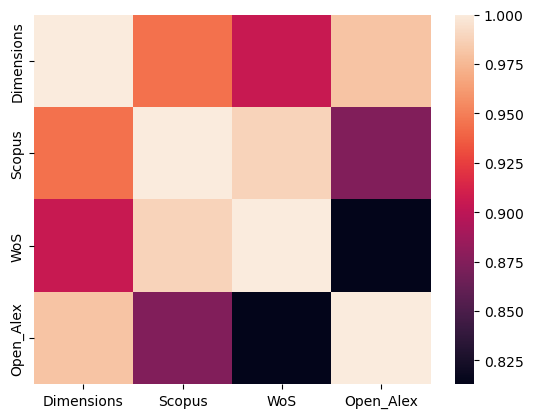

In [135]:
sns.heatmap(correlations)
plt.show()

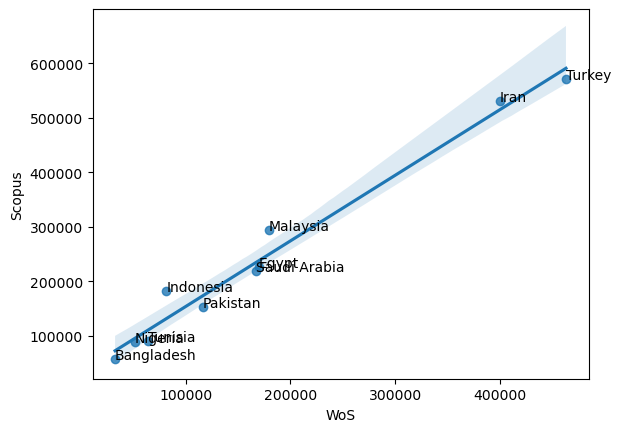

In [136]:
sns.regplot(x="WoS",
            y="Scopus", 
            data=df);
country = df['Country']
WoS = df['WoS']
Scopus = df['Scopus']

for i, country in enumerate (country):
    plt.annotate(country, (WoS[i]+0.7, Scopus[i]+0.5))

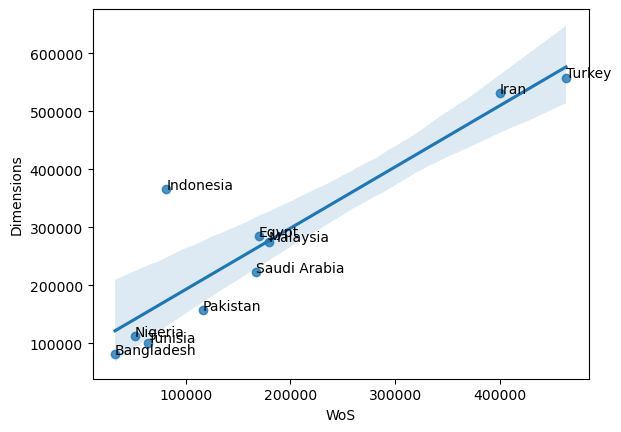

In [137]:
sns.regplot(x="WoS",
            y="Dimensions", 
            data=df);
country = df['Country']
WoS = df['WoS']
Dimensions = df['Dimensions']

for i, country in enumerate (country):
    plt.annotate(country, (WoS[i]+0.7, Dimensions[i]+0.5) )


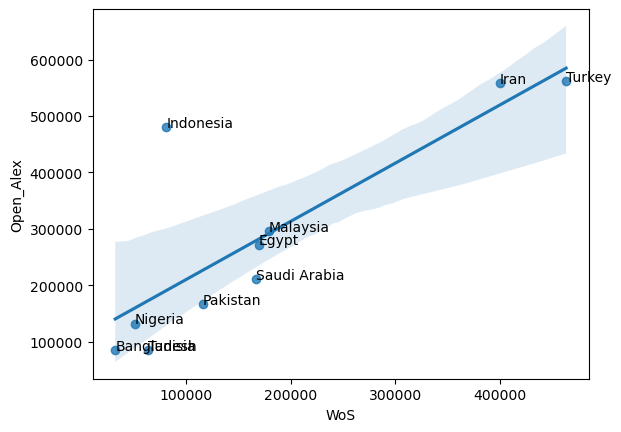

In [138]:
sns.regplot(x="WoS",
            y="Open_Alex", 
            data=df);

country = df['Country']
WoS = df['WoS']
Open_Alex = df['Open_Alex'] 
for i, country in enumerate (country):
    plt.annotate(country, (WoS[i]+0.7, Open_Alex[i]+0.5) )


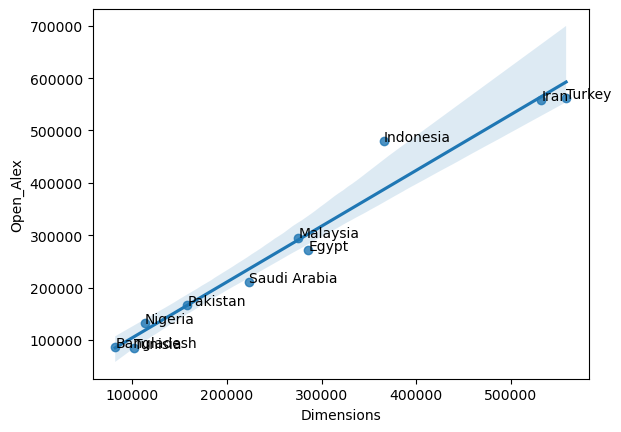

In [139]:
sns.regplot(x="Dimensions",
            y="Open_Alex", 
            data=df);
country = df['Country']
Dimensions = df['Dimensions']
Open_Alex = df['Open_Alex']
for i, country in enumerate (country):
    plt.annotate(country, (Dimensions[i]+0.7, Open_Alex[i]+0.5) )


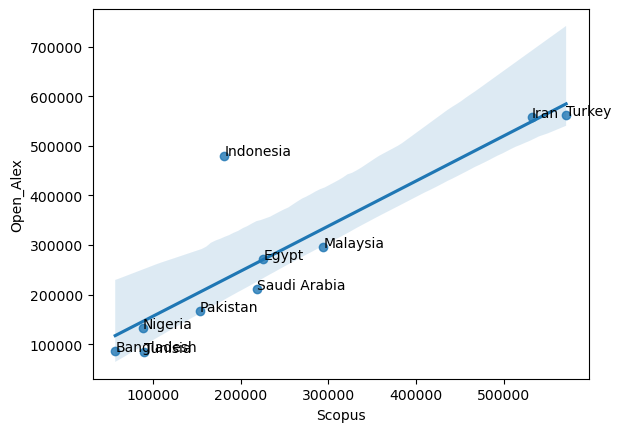

In [140]:
sns.regplot(x="Scopus",
            y="Open_Alex", 
            data=df);
country = df['Country']
Scopus = df['Scopus']
Open_Alex = df['Open_Alex']
for i, country in enumerate (country):
    plt.annotate(country, (Scopus[i]+0.7, Open_Alex[i]+0.5))


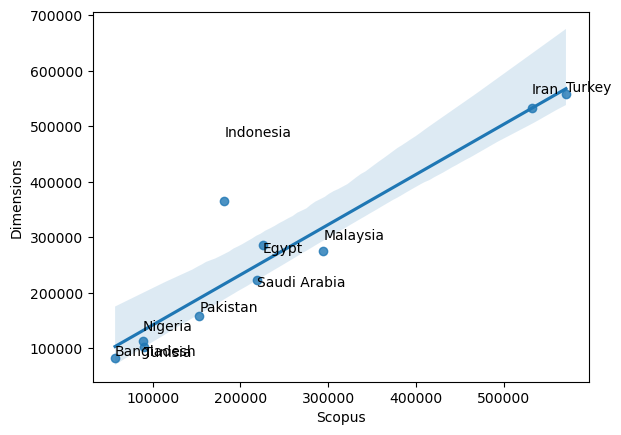

In [141]:
sns.regplot(x="Scopus",
            y="Dimensions", 
            data=df);
country = df['Country']
Scopus = df['Scopus']
Dimensions = df['Dimensions']
for i, country in enumerate (country):
    plt.annotate(country, (Scopus[i]+0.7, Open_Alex[i]+0.5))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings


In [ ]:
#SQL script
/****** Script for COUNTING THE TOTAL CITATIONS OF PUBS PER COUNTRY IN DIFFERENT DATABASES  ******/

DROP TABLE #1
SELECT distinct PUB_DOI, COUNTRY, DIMENSIONS_CITS, SCOPUS_CITS, WOS_CITS, ALEX_CITS
  INTO #1
  FROM [userdb_hayatdavoudij].[dbo].[citation_compare]
  where COUNTRY in ('TURKEY', 'IRAN', 'EGYPT', 'SAUDI ARABIA', 'MALAYSIA', 'PAKISTAN', 'NIGERIA', 'INDONESIA', 'TUNISIA', 'BANGLADESH')
  and  DIMENSIONS_CITS is not null and SCOPUS_CITS is not null and WOS_CITS is not null and ALEX_CITS is not null


  SELECT COUNTRY
  , sum(DIMENSIONS_CITS) as Dimensions_cits, sum(SCOPUS_CITS) as Scopus_cits, sum(WOS_CITS) as WoS_cits, sum(ALEX_CITS) as Openalex_cits
  FROM #1
  GROUP BY COUNTRY

In [13]:
df_cits=pd.read_excel(r'D:\10 COUNTRIES COMPARE\Data\n_cits.xlsx')

In [14]:
df_cits.head(10)

,COUNTRY,Dimensions_cits,Scopus_cits,WoS_cits,Openalex_cits
0,Bangladesh,1171378,1023451,900337,1214012
1,Egypt,3630579,3365302,2939830,3735356
2,Indonesia,1209523,1096001,901030,1235001
3,Iran,7977807,7492500,6608054,8167360
4,Malaysia,4055934,3769970,3161617,4176699
5,Nigeria,1185266,1029306,851818,1256577
6,Pakistan,2979513,2681129,2356808,3077944
7,Saudi Arabia,4667233,4154778,3732889,4757857
8,Tunisia,1192922,1096593,952061,1215271
9,Turkey,9314313,8862626,7512154,9615676


                 Dimensions_cits  Scopus_cits  WoS_cits  Openalex_cits
Dimensions_cits         1.000000     0.999616  0.999650       0.999961
Scopus_cits             0.999616     1.000000  0.999278       0.999709
WoS_cits                0.999650     0.999278  1.000000       0.999478
Openalex_cits           0.999961     0.999709  0.999478       1.000000


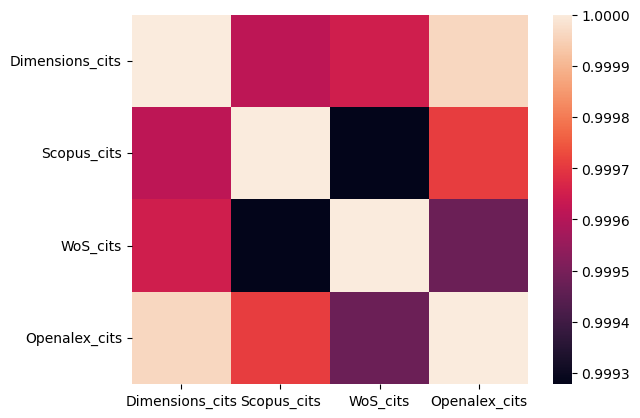

In [16]:
#calculate correlations between publication citations per country in different databases . 

corr_matrix = df_cits.corr()
print(corr_matrix)
sns.heatmap(corr_matrix)
plt.show()


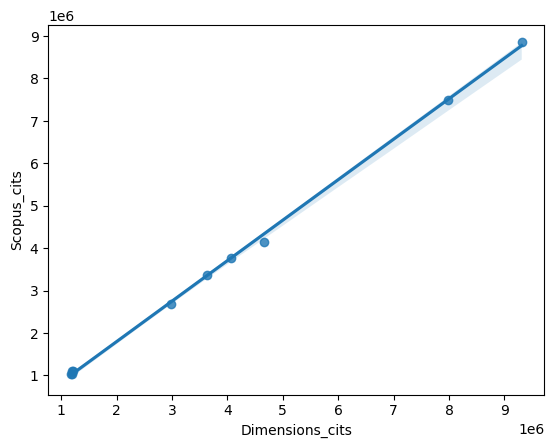

In [18]:
sns.regplot(x="Dimensions_cits",
            y="Scopus_cits", 
            data=df_cits);

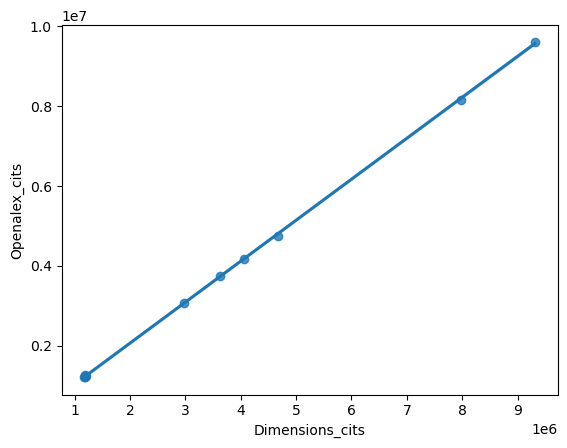

In [19]:
sns.regplot(x="Dimensions_cits",
            y="Openalex_cits", 
            data=df_cits);

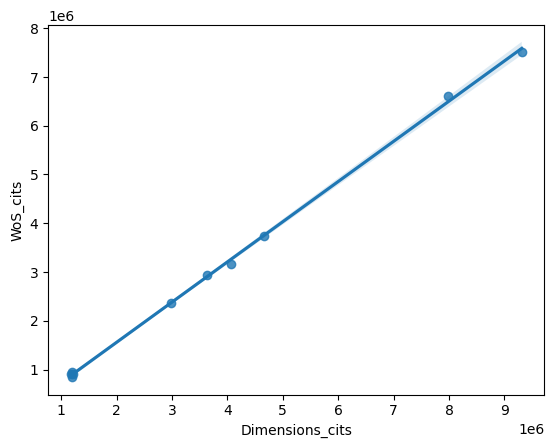

In [20]:
sns.regplot(x="Dimensions_cits",
            y="WoS_cits", 
            data=df_cits);

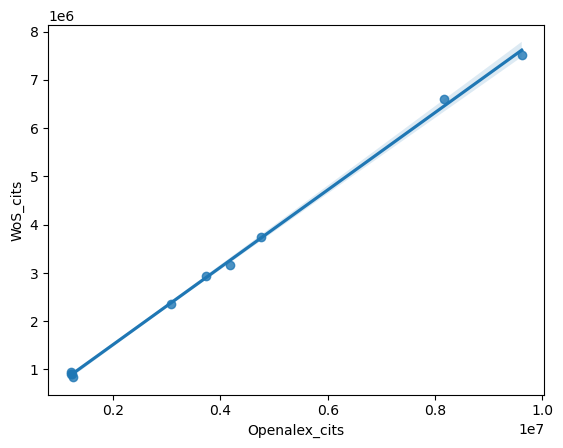

In [21]:
sns.regplot(x='Openalex_cits', y='WoS_cits', data=df_cits);

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import random
from datetime import datetime, timedelta

In [ ]:
#SQL script
DROP TABLE #1
Select distinct c.country, a.pub_year, count(distinct a.doi) as Scopus_pubs
INTO #1
from scopus_2022apr.dbo.pub as a
join scopus_2022apr.dbo.pub_affiliation as b on a.eid=b.eid
join scopus_2022apr.dbo.country as c on b.country_iso_alpha3_code=c.country_iso_alpha3_code
where b.country_iso_alpha3_code IN ('EGY', 'IDN', 'IRN', 'MYS', 'PAK', 'SAU', 'TUR', 'BGD', 'NGA', 'TUN') and pub_year between 1980 and 2020 
group by c.country, a.pub_year
order by c.country, a.pub_year

--3020867

DROP TABLE #2
Select distinct c.country, a.pub_year, count(distinct a.doi) as Dimensions_pubs
INTO #2
from dimensions_2022jun.dbo.pub as a 
join dimensions_2022jun.dbo.pub_affiliation_country as b on a.pub_id=b.pub_id
join dimensions_2022jun.dbo.country as c on b.country_code=c.country_code
where b.country_code IN ('EG','ID','IR','MY','PK','SA', 'TR', 'BD', 'TN', 'NG') and pub_year between 1980 and 2020 
group by c.country, a.pub_year
order by c.country, a.pub_year

--3050401

DROP TABLE #3
SELECT DISTINCT C.country, A.pub_year, count(distinct A.doi) as WoS_pubs
INTO #3
FROM wos_2213.dbo.pub AS A
JOIN wos_2213.dbo.pub_affiliation AS B ON (A.ut=B.ut)
JOIN wos_2213.dbo.country AS C ON (B.country_id = C.country_id)
WHERE B.country_id IN (62,96,97,125,157,178,214,18,151,213) and pub_year between 1980 and 2020 
group by c.country, a.pub_year
order by c.country, a.pub_year

--2365234

DROP TABLE #4
SELECT DISTINCT C.country, W.pub_year, count(distinct W.doi) as Openalex_pubs
INTO #4
FROM [openalex_2022oct].dbo.work AS W
JOIN [openalex_2022oct].dbo.work_institution AS WINST ON (W.work_id = WINST.work_id)
JOIN [openalex_2022oct].dbo.institution AS INST ON (WINST.institution_id = INST.institution_id)
JOIN [openalex_2022oct].dbo.country AS C ON (INST.country_iso_alpha2_code = C.country_iso_alpha2_code)
WHERE W.work_type_id IN (1, 2, 3, 4, 5, 8, 11, 14, 19, 21, 23, 24) AND INST.country_iso_alpha2_code IN 
('EG','ID','IR','MY','PK','SA', 'TR', 'BD', 'TN', 'NG')
and pub_year between 1980 and 2020 
group by c.country, w.pub_year
order by c.country, w.pub_year

--3598029

SELECT #2.country, #2.pub_year, #4.Openalex_pubs, #2.Dimensions_pubs,  #1.Scopus_pubs, #3.WoS_pubs
FROM #2
LEFT JOIN #1 ON (#2.country = #1.country and #2.pub_year = #1.pub_year)
LEFT JOIN #3 ON (#2.country = #3.country and #2.pub_year = #3.pub_year)
LEFT JOIN #4 ON (#2.country = #4.country and #2.pub_year = #4.pub_year)
GROUP BY #2.country, #2.pub_year, #4.Openalex_pubs, #2.Dimensions_pubs,  #1.Scopus_pubs, #3.WoS_pubs

In [83]:
df_1=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'BD')
df_2=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'EG')
df_3=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'ID')
df_4=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'IR')
df_5=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'MY')
df_6=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'NG')
df_7=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'PK')
df_8=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'SA')
df_9=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'TN')
df_10=pd.read_excel(R'D:\10 COUNTRIES COMPARE\Data\n_pubs_by_year_country.xlsx', sheet_name = 'TR')

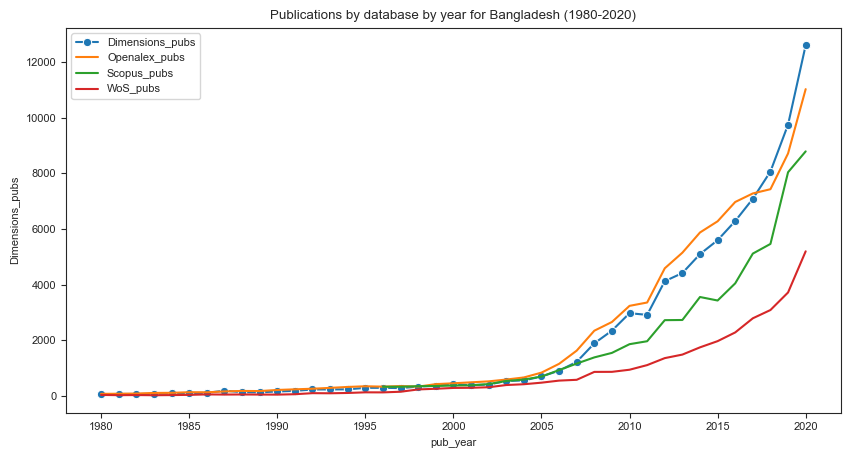

In [132]:
#How does the share of publications of a given country differ in different databases??
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Bangladesh (1980-2020)')
ax= sns.lineplot(data=df_1, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_1, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_1, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_1, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

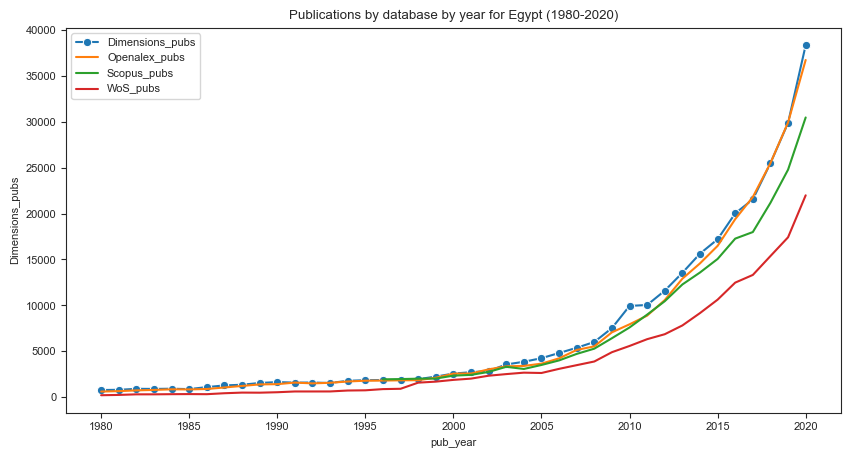

In [131]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Egypt (1980-2020)')
ax= sns.lineplot(data=df_2, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_2, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_2, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_2, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

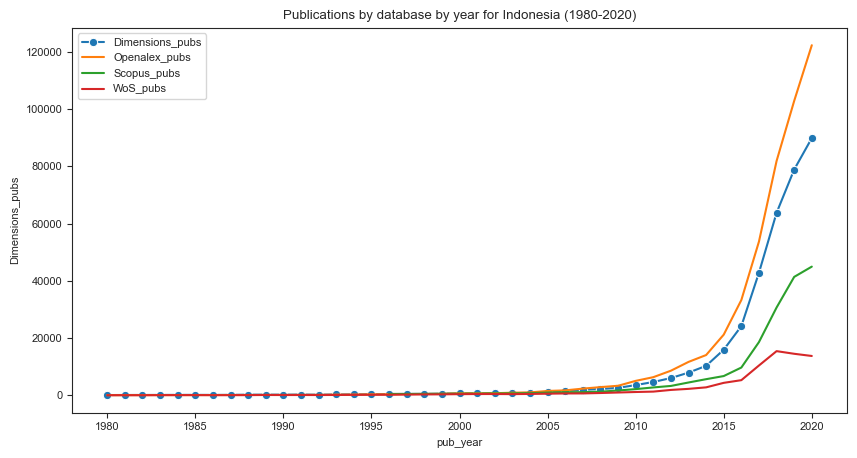

In [130]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Indonesia (1980-2020)')
ax= sns.lineplot(data=df_3, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_3, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_3, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_3, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

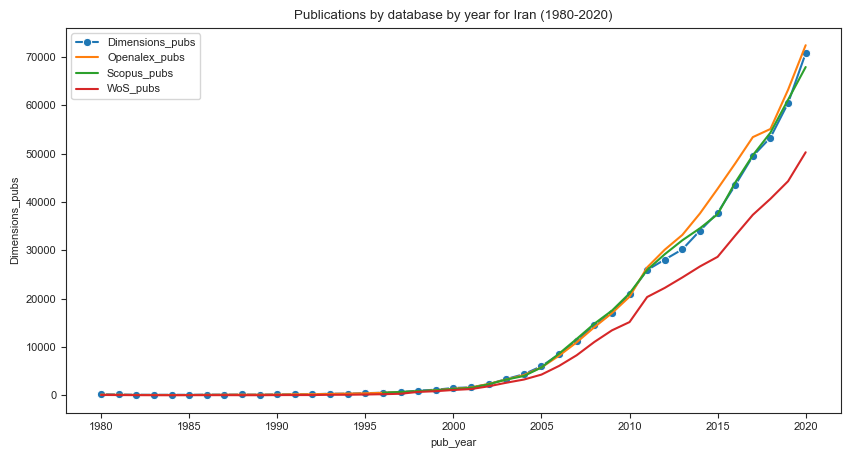

In [129]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Iran (1980-2020)')
ax= sns.lineplot(data=df_4, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_4, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_4, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_4, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

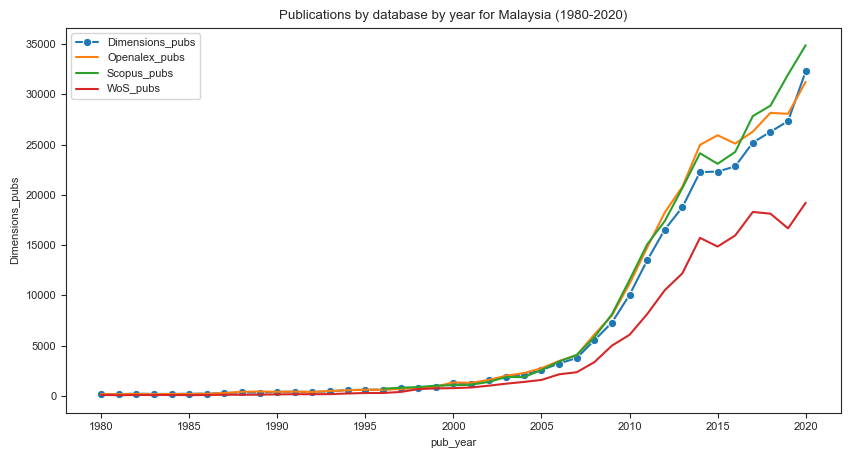

In [128]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Malaysia (1980-2020)')
ax= sns.lineplot(data=df_5, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_5, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_5, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_5, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

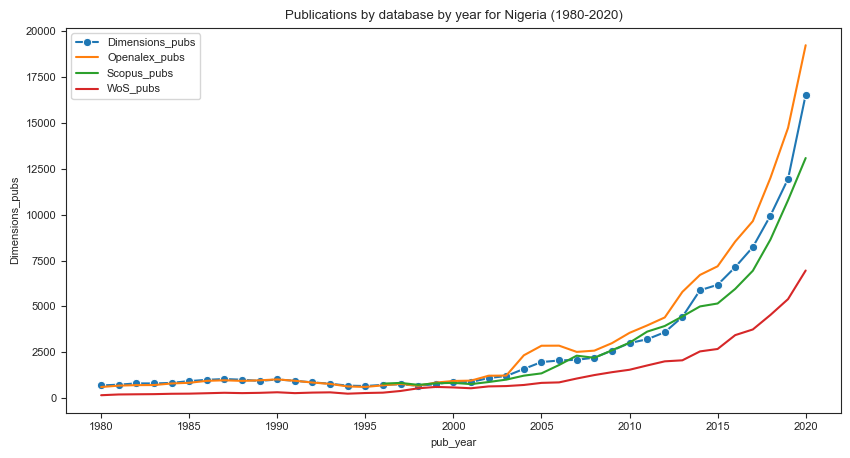

In [127]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Nigeria (1980-2020)')
ax= sns.lineplot(data=df_6, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_6, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_6, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_6, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

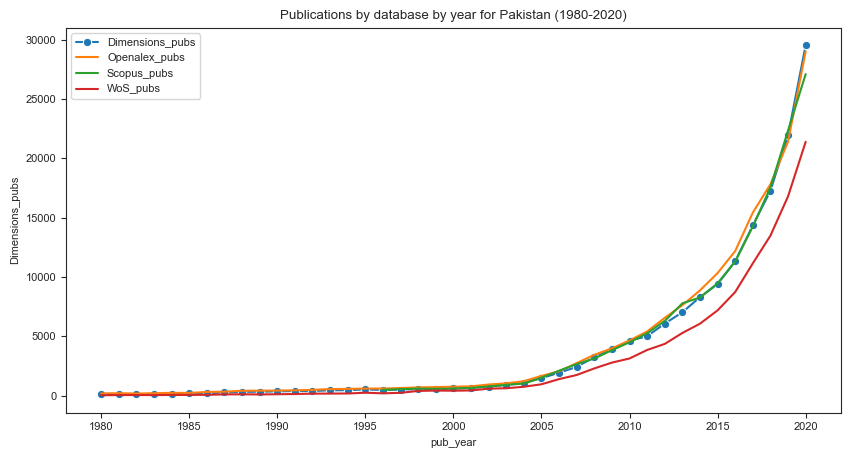

In [126]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Pakistan (1980-2020)')
ax= sns.lineplot(data=df_7, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_7, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_7, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_7, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

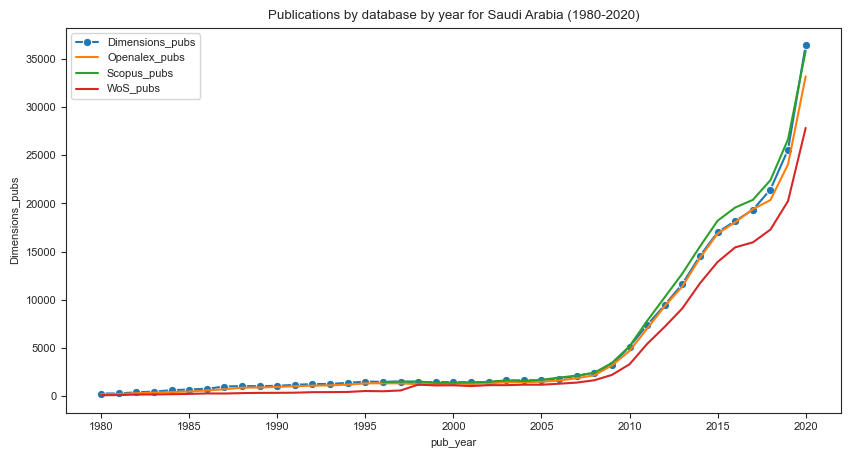

In [125]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Saudi Arabia (1980-2020)')
ax= sns.lineplot(data=df_8, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_8, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_8, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_8, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

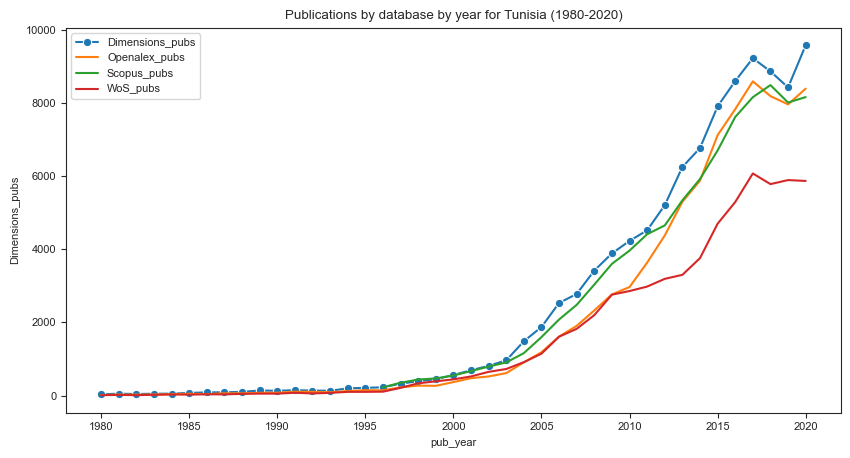

In [124]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Tunisia (1980-2020)')
ax= sns.lineplot(data=df_9, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_9, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_9, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_9, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

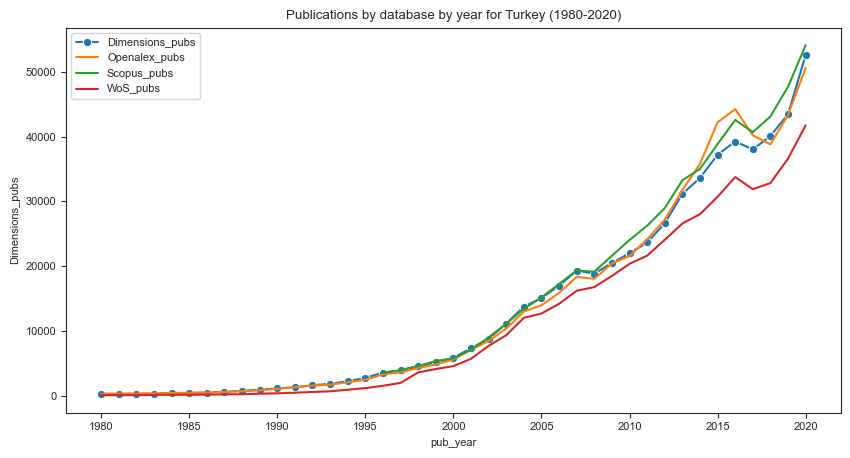

In [123]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
plt.title('Publications by database by year for Turkey (1980-2020)')
ax= sns.lineplot(data=df_10, x="pub_year", y="Dimensions_pubs", label = "Dimensions_pubs", marker='o')
ax1 = sns.lineplot(data=df_10, x="pub_year", y="Openalex_pubs", label = "Openalex_pubs")
ax2 = sns.lineplot(data=df_10, x="pub_year", y="Scopus_pubs", label = "Scopus_pubs")
ax3 = sns.lineplot(data=df_10, x="pub_year", y="WoS_pubs", label = "WoS_pubs")

In [ ]:
#SQL script
#2. for the 50%, find the concepts?

drop table #alexwosconcept
SELECT distinct A.PUB_DOI, C.concept_id, D.concept, D.description
into #alexwosconcept
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
LEFT JOIN openalex_2022oct.dbo.work AS B ON (A.PUB_DOI = B.doi)
LEFT JOIN openalex_2022oct.dbo.work_concept AS C ON (B.work_id = C.work_id)
LEFT JOIN openalex_2022oct.DBO.concept AS D ON (C.concept_id = D.concept_id)
WHERE A.ALEX_DOI = 1 AND A.wos_doi = 1

SELECT DISTINCT concept, COUNT(concept_id) AS CONCEPT_FREQUENCY
from #alexwosconcept
GROUP BY concept
order by CONCEPT_FREQUENCY desc;

In [151]:
df_total=pd.read_excel(r"D:\10 COUNTRIES COMPARE\Data\total pubs by database.xlsx")

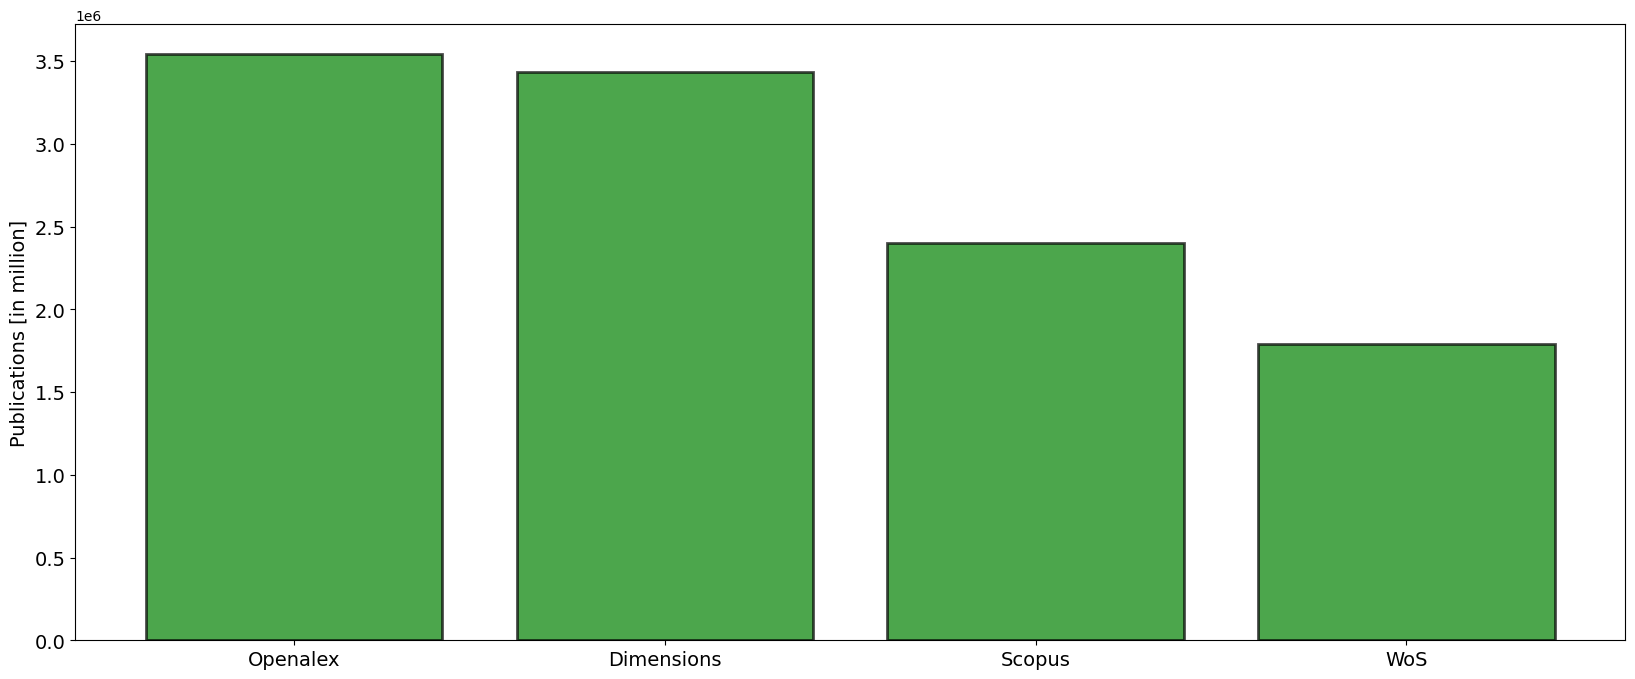

In [159]:
plt.figure(figsize=(20, 8))
heights = df_total['publications']
x_pos = ['Openalex', 'Dimensions', 'Scopus', 'WoS']

plt.bar(x_pos, heights, color = 'g', edgecolor = 'k', linewidth=2, alpha=0.7)
#plt.title('Total number of publications covered by database')
#plt.xlabel('Database', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Publications [in million]', fontsize = 14)
ax.set_yscale('symlog')

plt.show()

In [8]:
#!pip install matplotlib_venn
%matplotlib inline
from matplotlib_venn import venn2
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
import matplotlib.pyplot as plt

In [ ]:
#SQL script
/****** Script for finding database intersections and uniques ******/
DROP TABLE IF EXISTS #1
SELECT [country_code]
      ,[scopus]
      ,[dimensions]
      ,[wos]
      ,[openalex]
      ,[pubs]
	 INTO #1
  FROM [userdb_hayatdavoudij].[dbo].[pivot_summary]
  where country_code in ('EG', 'ID', 'IR', 'MY', 'PK', 'SA', 'TR', 'BD', 'TN', 'NG')
  order by country_code
 
  SELECT COUNTRY_CODE, 
  CASE WHEN SCOPUS = 0 AND DIMENSIONS = 0 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_unique_pubs
  , CASE WHEN SCOPUS = 0 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS WoS_unique_pubs
  , CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 0 THEN pubs end AS Dimensions_unique_pubs
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 0 AND OPENALEX = 0 THEN pubs end AS Scopus_unique_pubs
  
  ,CASE WHEN SCOPUS = 0 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS Openalex_WoS_intersection
  , CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_Dimensions_intersection
  ,CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS Dimensions_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_Scopus_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS Scopus_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 0 THEN pubs end AS Dimensions_Scopus_intersection
  ,CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS Openalex_Dimensions_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS Openalex_Scopus_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_Dimensions_Scopus_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS Dimensions_Scopus_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS All_databases_intersection
  FROM #1
order by country_code


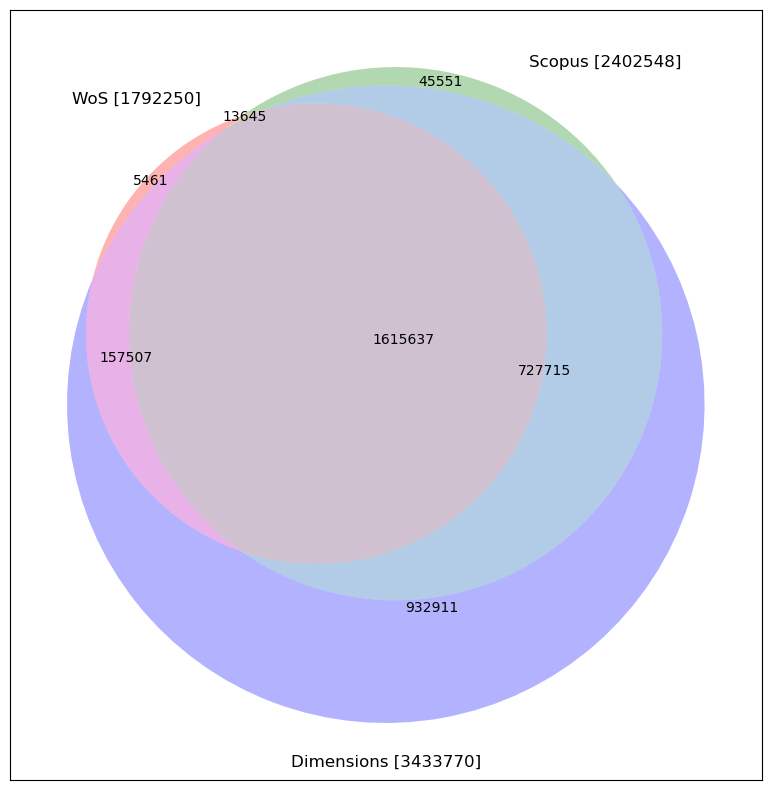

In [167]:
#syntax>> items=[A,B,ab,C,ac,bc,abc] >>[1792250,2402548,1629282,3433770,1773144,2343352,1615637]
#abc:1615637
#ab:13645
#ac:157507
#bc:727715
#a:5461  
#b:45551 
#c:932911
fig = plt.figure(figsize=(20, 10))
items = [5461,45551,13645,932911,157507,727715,1615637]
labels = ['WoS [1792250]', 'Scopus [2402548]', 'Dimensions [3433770]']
venn3(subsets=items,set_labels=labels, alpha=0.3)
plt.axis('on')

plt.show()

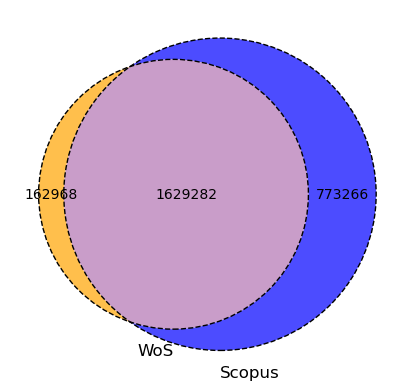

In [214]:
#ab:1629282

venn2(subsets=(162968, 773266, 1629282),
set_labels=('WoS', 'Scopus'),
set_colors=("orange", "blue"), alpha=0.7)

venn2_circles(subsets=(162968, 773266, 1629282), linestyle="dashed", linewidth=1)
plt.show()




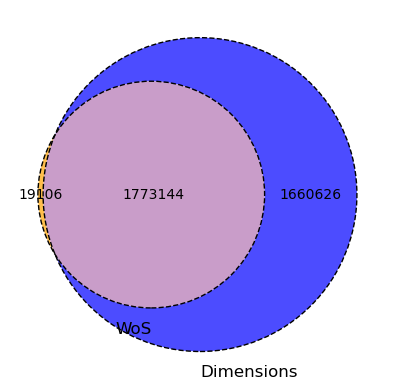

In [12]:
#ab:1773144

venn2(subsets=(19106,1660626,1773144),
set_labels=('WoS', 'Dimensions'),
set_colors=("orange", "blue"), alpha=0.7)

venn2_circles(subsets=(19106,1660626,1773144), linestyle="dashed", linewidth=1)
plt.show()


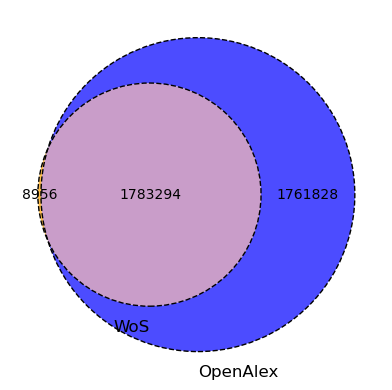

In [13]:
#ab:1783294

venn2(subsets=(8956,1761828,1783294),
set_labels=('WoS', 'OpenAlex'),
set_colors=("orange", "blue"), alpha=0.7)

venn2_circles(subsets=(8956,1761828,1783294), linestyle="dashed", linewidth=1)
plt.show()

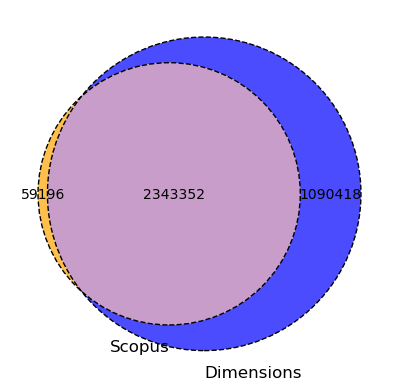

In [217]:
#ab: 2343352

venn2(subsets=(59196,1090418,2343352),
set_labels=('Scopus', 'Dimensions'),
set_colors=("orange", "blue"), alpha=0.7)

venn2_circles(subsets=(59196,1090418,2343352), linestyle="dashed", linewidth=1)
plt.show()

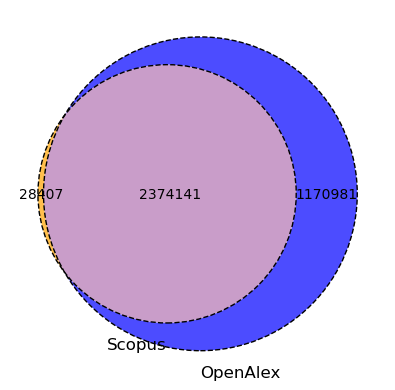

In [218]:
#ab: 2374141

venn2(subsets=(28407,1170981,2374141),
set_labels=('Scopus', 'OpenAlex'),
set_colors=("orange", "blue"), alpha=0.7)

venn2_circles(subsets=(28407,1170981,2374141), linestyle="dashed", linewidth=1)
plt.show()

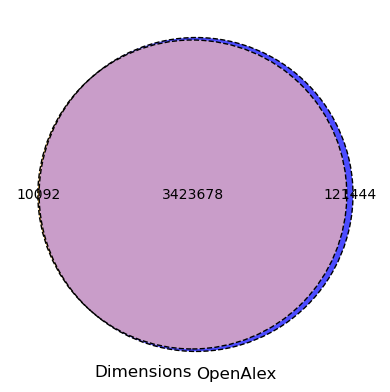

In [219]:
#ab:3423678 

venn2(subsets=(10092,121444,3423678),
set_labels=('Dimensions', 'OpenAlex'),
set_colors=("orange", "blue"), alpha=0.7)

venn2_circles(subsets=(10092,121444,3423678), linestyle="dashed", linewidth=1)
plt.show()

In [ ]:
#SQL script
#What are the implications of different coverage capacity of databases for analysis at different levels of aggregate?
        
drop table if exists #1
select distinct a.pub_doi, c.organization_enhanced_id, d.organization_enhanced
into #1
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
inner join wos_2213.dbo.pub as b on a.PUB_DOI = b.doi
left join wos_2213.dbo.pub_affiliation_organization_enhanced as c on b.ut = c.ut
left join wos_2213.dbo.organization_enhanced as d on c.organization_enhanced_id = d.organization_enhanced_id
where a.WOS_DOI = 1 and a.ALEX_DOI = 1

select organization_enhanced, count(organization_enhanced_id) as n_pubs_per_institution
from #1
group by organization_enhanced
order by n_pubs_per_institution desc;

In [5]:
df_insts_1=pd.read_excel(r"D:\10 COUNTRIES COMPARE\Data\alexwosinstitutions.xlsx", sheet_name = 'alexwos')

In [6]:
df_insts_1.head(5)

,institution,n_pubs_per_institution
0,Islamic Azad University,64031
1,King Saud University,43068
2,University of Tehran,38657
3,Universiti Malaya,37943
4,King Abdulaziz University,35576


In [ ]:
#SQL script
#openalex_only institutions

drop table if exists #1
select distinct a.pub_doi, c.institution_id, d.institution
into #1
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
left join openalex_2022oct.dbo.work as b on (a.pub_doi = b.doi)
left join [openalex_2022oct].dbo.work_institution AS c ON (b.work_id = c.work_id)
left join [openalex_2022oct].dbo.institution AS d ON (c.institution_id = d.institution_id)
where a.alex_doi = 1 and a.wos_doi = 0

select institution, count(institution_id) as n_pubs_per_institution
from #1
group by institution
order by n_pubs_per_institution desc;

In [242]:
df_insts_2=pd.read_excel(r"D:\10 COUNTRIES COMPARE\Data\alexwosinstitutions.xlsx", sheet_name = 'alexonly')
df_insts_2.head(5)

,institution,n_pubs_per_institution
0,Cairo University,19674
1,University of Indonesia,18023
2,University of Technology Malaysia,17347
3,Gadjah Mada University,16247
4,University of Tehran,15774


# top instiutions per database

In [ ]:
#SQL script
#openalex institutions

drop table if exists #1
select distinct a.pub_doi, c.institution_id, d.institution
into #1
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
left join openalex_2022oct.dbo.work as b on (a.pub_doi = b.doi)
left join [openalex_2022oct].dbo.work_institution AS c ON (b.work_id = c.work_id)
left join [openalex_2022oct].dbo.institution AS d ON (c.institution_id = d.institution_id)
where a.alex_doi = 1 

select institution, count(institution_id) as n_pubs_per_institution
from #1
group by institution
order by n_pubs_per_institution desc;
----------------------------------------------------------------------------------------------------------------------
#wos institutions

drop table if exists #1
select distinct a.pub_doi, c.organization_enhanced_id, d.organization_enhanced
into #1
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
left join wos_2213.dbo.pub as b on a.PUB_DOI = b.doi
left join wos_2213.dbo.pub_affiliation_organization_enhanced as c on b.ut = c.ut
left join wos_2213.dbo.organization_enhanced as d on c.organization_enhanced_id = d.organization_enhanced_id
where a.WOS_DOI = 1

select organization_enhanced, count(organization_enhanced_id) as n_pubs_per_institution
from #1
group by organization_enhanced
order by n_pubs_per_institution desc;
----------------------------------------------------------------------------------------------------------------------
#dimensions

drop table if exists #1
select distinct a.pub_doi, c.grid_id, d.organization_name
into #1
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
left join dimensions_2022jun.dbo.pub as b on a.PUB_DOI = b.doi
left join dimensions_2022jun.dbo.pub_affiliation_organization as c on b.pub_id = c.pub_id
left join dimensions_2022jun.dbo.organization as d on c.grid_id = d.grid_id
where a.DIMENSIONS_DOI = 1

select organization_name, count(grid_id) as n_pubs_per_institution
from #1
group by organization_name
order by n_pubs_per_institution desc;
------------------------------------------------------------------------------------------------------------------------
#scopus

drop table if exists #1
select distinct a.pub_doi, c.organization_id, d.organization
into #1
FROM [userdb_hayatdavoudij].[dbo].[ten_countries] AS A
left join scopus_2022apr.dbo.pub as b on a.PUB_DOI = b.doi
left join scopus_2022apr.dbo.pub_affiliation_organization as c on b.eid = c.eid
left join scopus_2022apr.dbo.organization as d on c.organization_id = d.organization_id
where a.SCOPUS_DOI = 1

select organization, count(organization_id) as n_pubs_per_institution
from #1
group by organization
order by n_pubs_per_institution desc;

In [ ]:
#SQL script   
#######################################################################################################################
SELECT distinct a.[PUB_DOI], b.n_refs as dimension_refs, concat(c.author_first, '; ' , c.author_et_al) as dimension_authors,
d.n_refs as scopus_refs, concat(e.author_first, '; ' , e.author_et_al) as scopus_authors,
f.n_refs as wos_refs, concat(g.author_first, '; ', g.author_et_al) as wos_authors,
h.n_refs as openalex_refs, concat(i.author_first, '; ', i.author_et_al) as openalex_authors
into [userdb_hayatdavoudij].[dbo].[metadata_inconsistency]
  FROM [userdb_hayatdavoudij].[dbo].[ten_countries] as a
  left join dimensions_2022jun.dbo.pub as b on (a.pub_doi = b.doi)
  left join dimensions_2022jun.dbo.pub_detail as c on (a.pub_doi = c.doi)
  left join scopus_2022apr.dbo.pub as d on (a.pub_doi = d.doi)
  left join scopus_2022apr.dbo.pub_detail as e on (a.pub_doi = e.doi)
  left join wos_2213.dbo.pub as f on (a.pub_doi = f.doi)
  left join wos_2213.dbo.pub_detail as g on (a.pub_doi = g.doi)
  left join openalex_2022oct.dbo.work as h on (a.pub_doi = h.doi)
  left join openalex_2022oct.dbo.work_detail as i on (a.pub_doi = i.doi)
  where [DIMENSIONS_DOI] = 1 and [SCOPUS_DOI] = 1 and [WOS_DOI] = 1 and [ALEX_DOI] = 1
#####################################################################################################################
--

In [ ]:
#SQL script
SELECT count(distinct PUB_DOI) FROM 
        [userdb_hayatdavoudij].[dbo].[metadata_inconsistency] where 
		dimension_refs = scopus_refs and 
		dimension_refs = wos_refs --and
		dimension_refs = openalex_refs

In [ ]:
#SQL script
drop table #author_compare 
SELECT distinct pub_doi, (LEN(dimension_authors) - LEN(REPLACE(dimension_authors,';','')) + 1) AS Dimension_n_authors,
						(LEN(scopus_authors) - LEN(REPLACE(scopus_authors,';','')) + 1) AS scopus_n_authors,
						(LEN(wos_authors) - LEN(REPLACE(wos_authors,';','')) + 1) AS wos_n_authors,
						(LEN(openalex_authors) - LEN(REPLACE(openalex_authors,';','')) + 1) AS openalex_n_authors
into #author_compare 
FROM [userdb_hayatdavoudij].[dbo].[metadata_inconsistency]

select * from  #author_compare
where Dimension_n_authors = scopus_n_authors and Dimension_n_authors = wos_n_authors and Dimension_n_authors = openalex_n_authors 

In [ ]:
#SQL script
#Script for retriving the top 20 sources, research areas and n_pubs of the ID researchers' publications in WoS

DROP TABLE #WOS_DATASET
SELECT DISTINCT A.ut, A.pub_year, A.doi, B.country_id, C.country, d.source_id, d.source_title
, c.country_iso_alpha2_code 
INTO #WOS_DATASET
FROM wos_2213.dbo.pub AS A
left JOIN wos_2213.dbo.pub_affiliation AS B ON (A.ut=B.ut)
left JOIN wos_2213.dbo.country AS C ON (B.country_id = C.country_id)
left join wos_2213.dbo.source as d on (a.source_id = d.source_id)
WHERE B.country_id = 96 and pub_year between 1980 and 2020 and A.doi is not null

DROP TABLE #FREQUENCYCOUNT
SELECT top 20 SOURCE_ID, source_title, COUNT(source_id) AS n_pubs_per_source
INTO  #FREQUENCYCOUNT
FROM  #WOS_DATASET
GROUP BY SOURCE_ID, source_title
ORDER BY n_pubs_per_source DESC;

DROP TABLE #SR
SELECT A.*, B.research_area_id, C.research_area
INTO #SR
FROM #FREQUENCYCOUNT AS A
LEFT JOIN wos_2213.DBO.source_research_area AS B ON (A.source_id = B.source_id)
LEFT JOIN WOS_2213.DBO.research_area AS C ON (B.research_area_id = C.research_area_id)
ORDER BY n_pubs_per_source DESC;

SELECT source_title, n_pubs_per_source, STRING_AGG(research_area, ';') AS research_areas
FROM #SR
GROUP BY source_title, n_pubs_per_source
ORDER BY n_pubs_per_source DESC;

In [282]:
df_rvi = pd.read_excel(r"D:\10 COUNTRIES COMPARE\Data\ID_sample_wos.xlsx")

In [283]:
df_rvi.head()

,source_title,n_pubs_per_source,research_areas
0,AIP Conference Proceedings,9375,Engineering;Materials Science;Pharmacology & P...
1,IOP Conference Series-Earth and Environmental ...,9079,Energy & Fuels;Engineering;Mechanics;Water Res...
2,Journal of Physics Conference Series,8101,Construction & Building Technology;Energy & Fu...
3,IOP Conference Series-Materials Science and En...,6039,Engineering;Materials Science;Metallurgy & Met...
4,Advanced Science Letters,2237,Science & Technology - Other Topics


TypeError: 'str' object is not callable

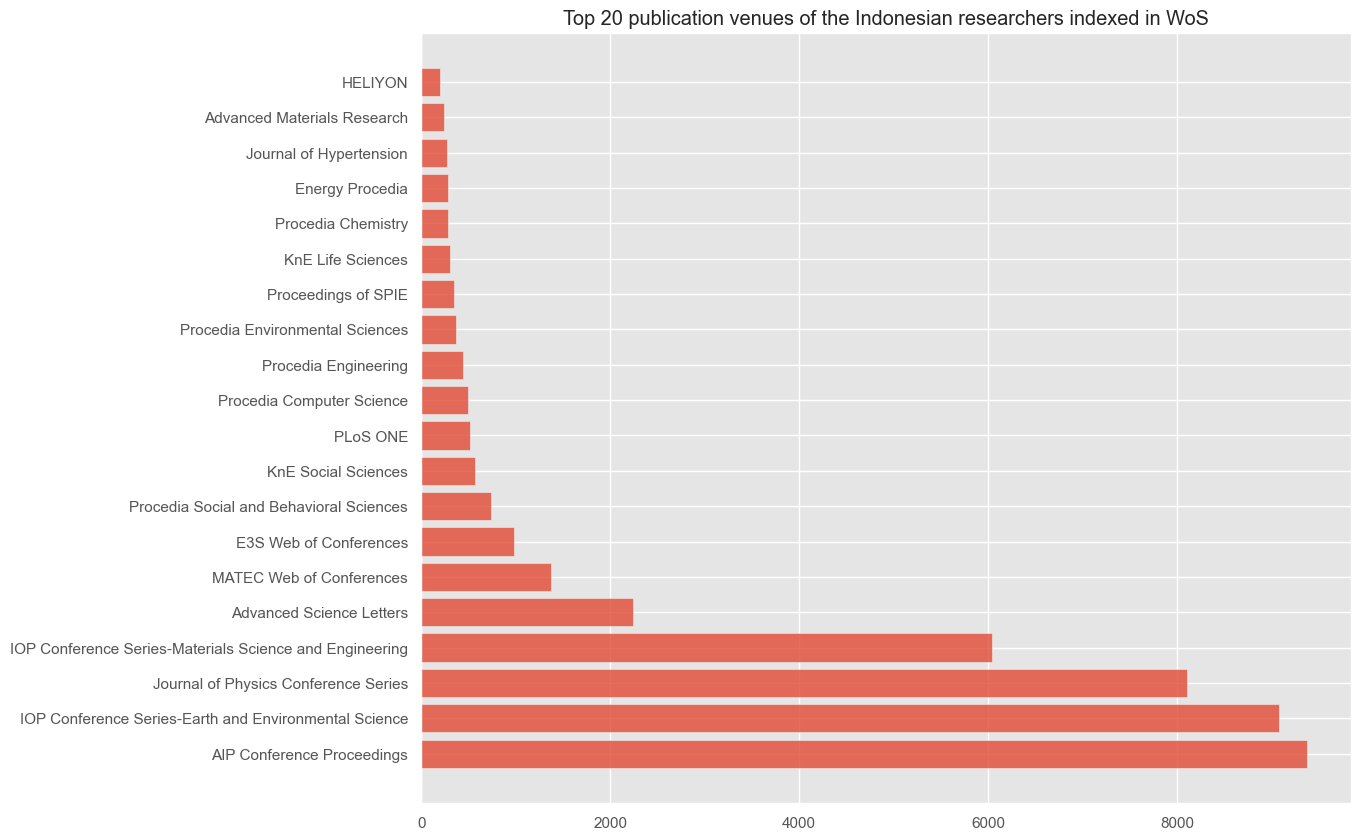

In [284]:
y_axis = df_rvi['source_title'].head(20)
x_axis = df_rvi['n_pubs_per_source'].head(20)

plt.style.use('ggplot')
plt.barh(y_axis, x_axis, alpha=0.8)
ax.invert_yaxis()
plt.title('Top 20 publication venues of the Indonesian researchers indexed in WoS')
plt.xlabel('# of publications')
plt.show()

TypeError: 'str' object is not callable

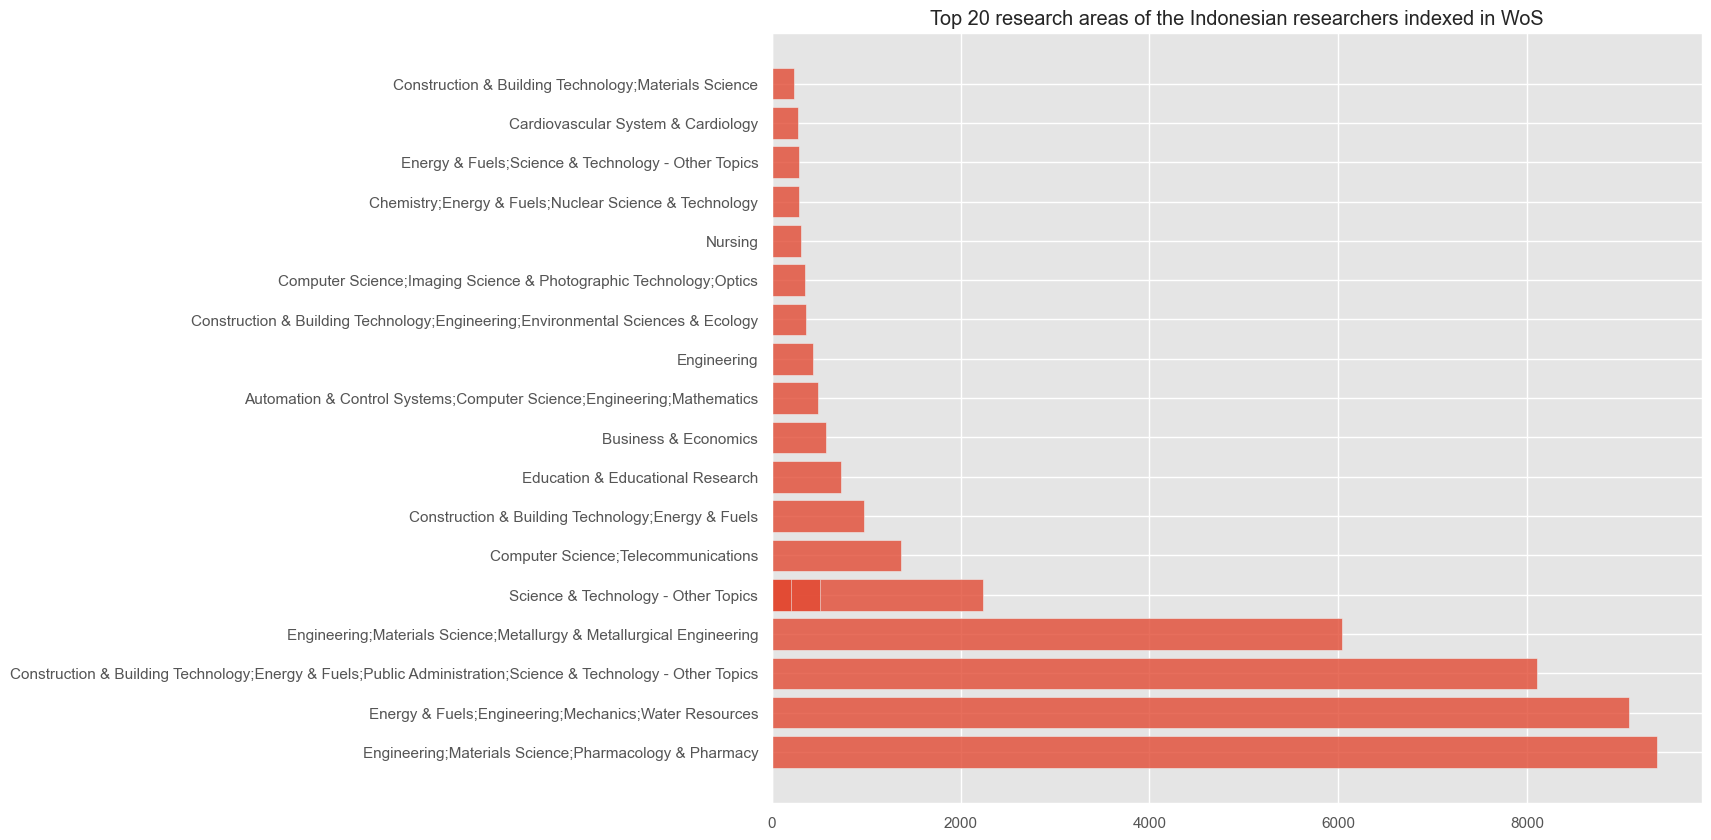

In [285]:
y_axis = df_rvi['research_areas'].head(20)
x_axis = df_rvi['n_pubs_per_source'].head(20)

plt.style.use('ggplot')
plt.barh(y_axis, x_axis, alpha=0.8)
ax.invert_yaxis()
plt.title('Top 20 research areas of the Indonesian researchers indexed in WoS')
plt.xlabel('publications count')
plt.show()

In [271]:
!pip install pyppeteer
'allow-chromium-download'

'allow-chromium-download'

In [ ]:
#SQL script
#SCRIPT FOR TOP 20 VENUES INDEXED IN OPEN_ALEX

DROP TABLE if exists #ALEX_DATASET
SELECT DISTINCT W.work_id, W.pub_year, W.doi, w.host_venue_id, d.venue 
INTO #ALEX_DATASET
FROM [openalex_2022oct].dbo.work AS W
left JOIN [openalex_2022oct].dbo.work_institution AS WINST ON (W.work_id = WINST.work_id)
left JOIN [openalex_2022oct].dbo.institution AS INST ON (WINST.institution_id = INST.institution_id)
left JOIN [openalex_2022oct].dbo.country AS C ON (INST.country_iso_alpha2_code = C.country_iso_alpha2_code)
left join [openalex_2022oct].dbo.venue as D on (w.host_venue_id = d.venue_id)
WHERE W.work_type_id IN (1, 2, 3, 4, 5, 8, 11, 14, 19, 21, 23, 24) AND INST.country_iso_alpha2_code = 'ID' and pub_year between 1980 and 2020
and W.doi is not null
--480433

SELECT top 20 host_venue_id, venue as source, COUNT(host_venue_id) AS n_pubs_per_source
FROM  #ALEX_DATASET as a
GROUP BY host_venue_id, venue
ORDER BY n_pubs_per_source DESC;

#SCRIPT FOR COUNTING THE TOP CONCEPT FREQUENCEY

DROP TABLE if exists #ALEX_DATASET
SELECT DISTINCT W.work_id, W.pub_year, W.doi, w.host_venue_id, d.venue, E.concept_id, F.concept 
INTO #ALEX_DATASET
FROM [openalex_2022oct].dbo.work AS W
left JOIN [openalex_2022oct].dbo.work_institution AS WINST ON (W.work_id = WINST.work_id)
left JOIN [openalex_2022oct].dbo.institution AS INST ON (WINST.institution_id = INST.institution_id)
left JOIN [openalex_2022oct].dbo.country AS C ON (INST.country_iso_alpha2_code = C.country_iso_alpha2_code)
left join [openalex_2022oct].dbo.venue as D on (w.host_venue_id = d.venue_id)
left join [openalex_2022oct].dbo.work_concept as E on (W.work_id = E.work_id)
left join [openalex_2022oct].dbo.concept as F on (E.concept_id = F.concept_id)
WHERE W.work_type_id IN (1, 2, 3, 4, 5, 8, 11, 14, 19, 21, 23, 24) AND INST.country_iso_alpha2_code = 'ID' and pub_year between 1980 and 2020
and W.doi is not null
--480433

SELECT top 20 concept, COUNT(concept_id) AS concept_freq
FROM  #ALEX_DATASET 
GROUP BY concept
ORDER BY  concept_freq DESC;

In [277]:
df_id_1 = pd.read_excel(r"D:\10 COUNTRIES COMPARE\Data\ID_sample_alex.xlsx", sheet_name = 'Sheet1')

TypeError: 'str' object is not callable

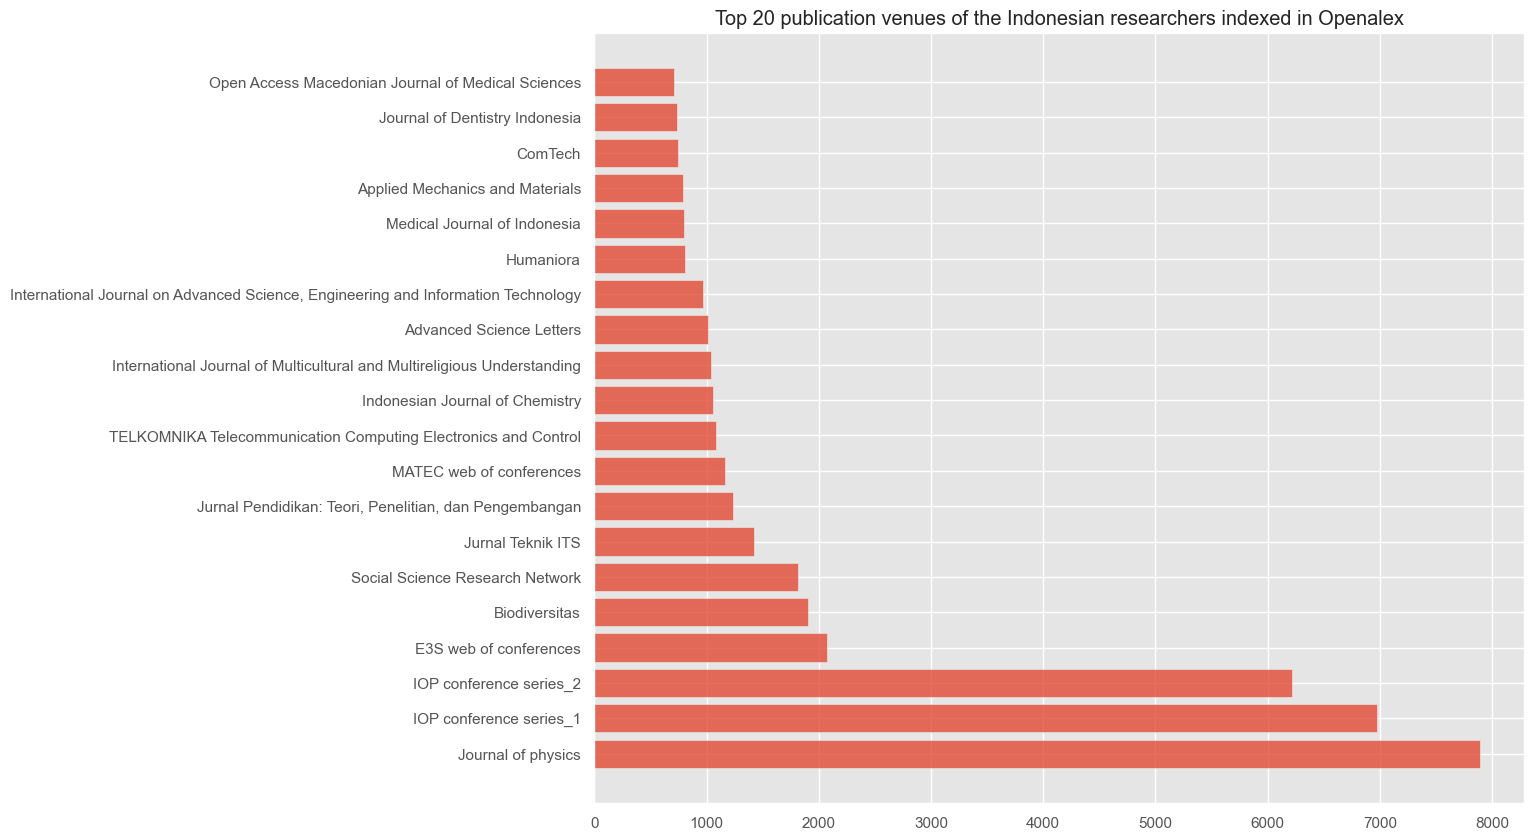

In [278]:
y_axis = df_id_1['source']
x_axis = df_id_1['n_pubs_per_source']

plt.style.use('ggplot')
plt.barh(y_axis, x_axis, alpha=0.8)
ax.invert_yaxis()
plt.title('Top 20 publication venues of the Indonesian researchers indexed in Openalex')
plt.xlabel('# of publications')
plt.show()

In [279]:
df_id_2= pd.read_excel(r"D:\10 COUNTRIES COMPARE\Data\ID_sample_alex.xlsx", sheet_name = 'Sheet2')

TypeError: 'str' object is not callable

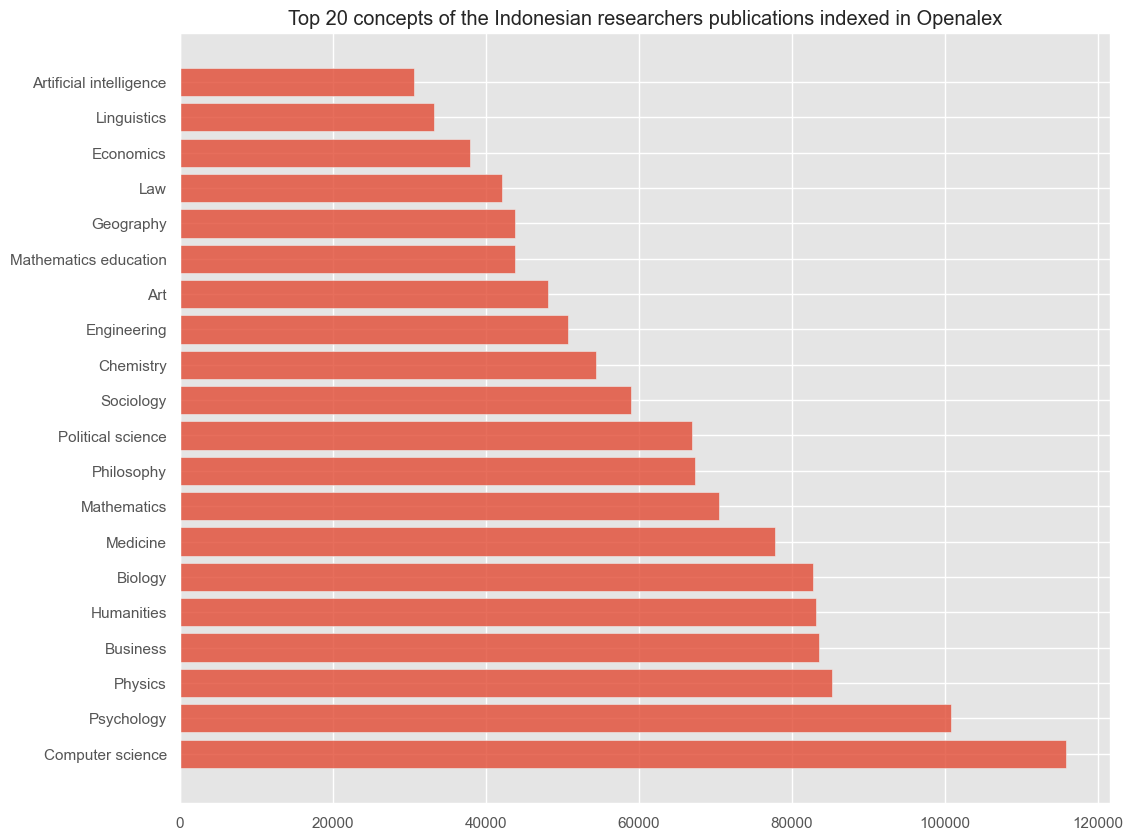

In [281]:
y_axis = df_id_2['concept']
x_axis = df_id_2['concept_freq']

plt.style.use('ggplot')
plt.barh(y_axis, x_axis, alpha=0.8)
ax.invert_yaxis()
plt.title('Top 20 concepts of the Indonesian researchers publications indexed in Openalex')
plt.xlabel('# of publications')
plt.show()

In [ ]:
#SQL script
#same doi but different id

select a.* from wos_2213.dbo.pub as a
inner join
wos_2213.dbo.pub as b on (a.doi = b.doi)
where a.doi = b.doi and a.ut != b.ut
order by a.doi

select a.* from scopus_2022apr.dbo.pub as a
inner join
scopus_2022apr.dbo.pub as b on (a.doi = b.doi)
where a.doi = b.doi and a.eid != b.eid
order by a.doi

select a.* from dimensions_2022jun.dbo.pub as a
inner join
dimensions_2022jun.dbo.pub as b on (a.doi = b.doi)
where a.doi = b.doi and a.pub_id != b.pub_id
order by a.doi

select a.* from openalex_2022oct.dbo.work as a
inner join
openalex_2022oct.dbo.work as b on (a.doi = b.doi)
where a.doi = b.doi and a.work_id != b.work_id
order by a.doi

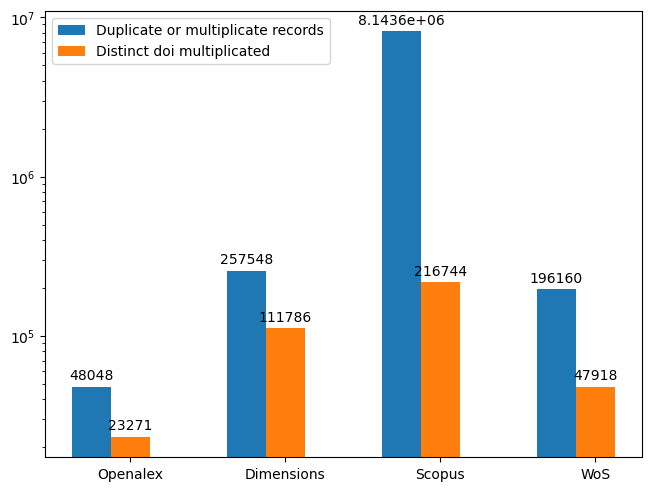

In [7]:
import numpy as np
databases = ("Openalex", "Dimensions", "Scopus", "WoS")
duplicates = {
    'Duplicate or multiplicate records': (48048, 257548, 8143596, 196160),
    'Distinct doi multiplicated': (23271, 111786, 216744, 47918)
}

x = np.arange(len(databases))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in duplicates.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('')
ax.set_xticks(x + width, databases)
ax.legend(loc='upper left')
ax.set_yscale('log')

plt.show()

In [ ]:
#SQL script
/****** Summarize the country output per database as unique or intersected coverage  ******/

DROP TABLE IF EXISTS #1
SELECT [country_code]
      ,[scopus]
      ,[dimensions]
      ,[wos]
      ,[openalex]
      ,[pubs]
	 INTO #1
  FROM [userdb_hayatdavoudij].[dbo].[pivot_summary]
  where country_code in ('EG', 'ID', 'IR', 'MY', 'PK', 'SA', 'TR', 'BD', 'TN', 'NG')
  order by country_code
 
  SELECT COUNTRY_CODE, 
  CASE WHEN SCOPUS = 0 AND DIMENSIONS = 0 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_unique_pubs
  , CASE WHEN SCOPUS = 0 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS WoS_unique_pubs
  , CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 0 THEN pubs end AS Dimensions_unique_pubs
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 0 AND OPENALEX = 0 THEN pubs end AS Scopus_unique_pubs
  
  ,CASE WHEN SCOPUS = 0 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS Openalex_WoS_intersection
  , CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_Dimensions_intersection
  ,CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS Dimensions_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_Scopus_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS Scopus_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 0 THEN pubs end AS Dimensions_Scopus_intersection
  ,CASE WHEN SCOPUS = 0 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS Openalex_Dimensions_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 0 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS Openalex_Scopus_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 0 AND OPENALEX = 1 THEN pubs end AS Openalex_Dimensions_Scopus_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 0 THEN pubs end AS Dimensions_Scopus_WoS_intersection
  ,CASE WHEN SCOPUS = 1 AND DIMENSIONS = 1 AND WOS = 1 AND OPENALEX = 1 THEN pubs end AS All_databases_intersection
  FROM #1
order by country_code


In [6]:
pip install upsetplot

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for upsetplot: filename=UpSetPlot-0.8.0-py3-none-any.whl size=23579 sha256=e39c657bf7f341a7df9fa9caa6b886b182e59d86dcb36dbffe37d8a39c0e212e
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\e2\6f\1d\2d6fe3ae1a2907eea035ea8e1d27b8f8de1ede6ad268c2be5c
Successfully built upsetplot
Note: you may need to restart the kernel to use updated packages.


In [111]:
import upsetplot 
import pandas as pd
from upsetplot import from_indicators
from upsetplot import from_memberships, UpSet
import matplotlib.pyplot as plt
from upsetplot import plot

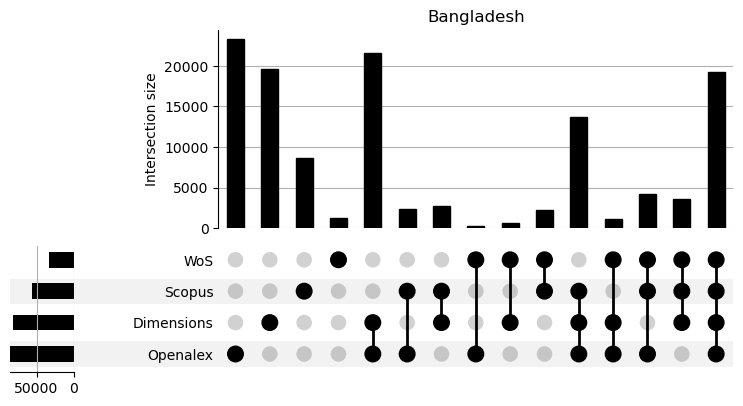

In [120]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[1233,8635,19556,23242,2243,237,586,2411,21523,2693,4233,1187,13672,3640,19247]
)

plot(df)
plt.title('Bangladesh')
plt.show() 

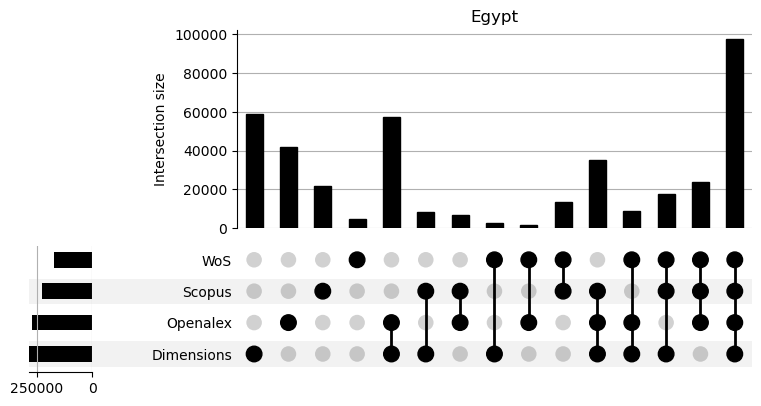

In [121]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[4885,21986,58821,41968,13320,1514,2629,6592,57319,8423,23718,8752,35094,17568,97327]
)

plot(df)
plt.title('Egypt')
plt.show(

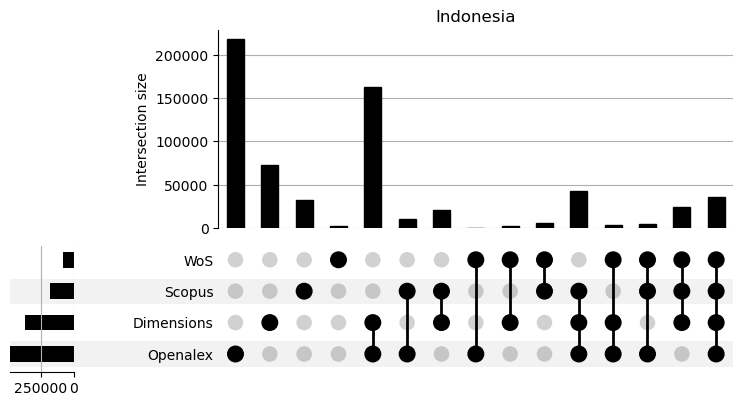

In [122]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[2750,32852,72427,217670,6040,390,2047,10832,163150,20438,5307,4171,43153,24865,35757]
)

plot(df)
plt.title('Indonesia')
plt.show() 

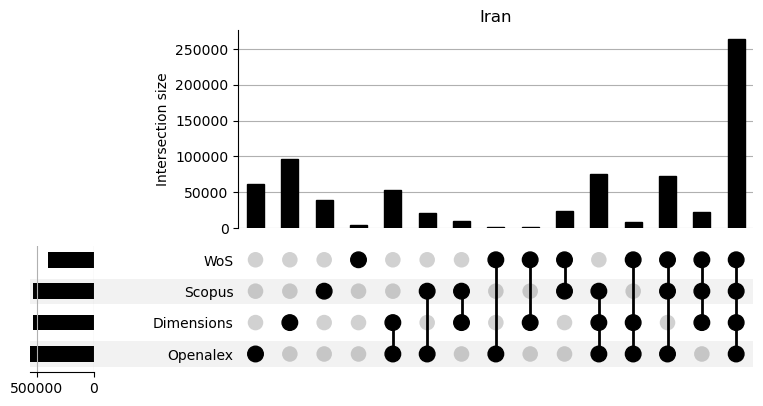

In [123]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[4647,39520,96516,61877,23954,1757,2345,21502,53532,10236,72867,8218,75122,23179,263029]
)

plot(df)
plt.title('Iran')
plt.show() 

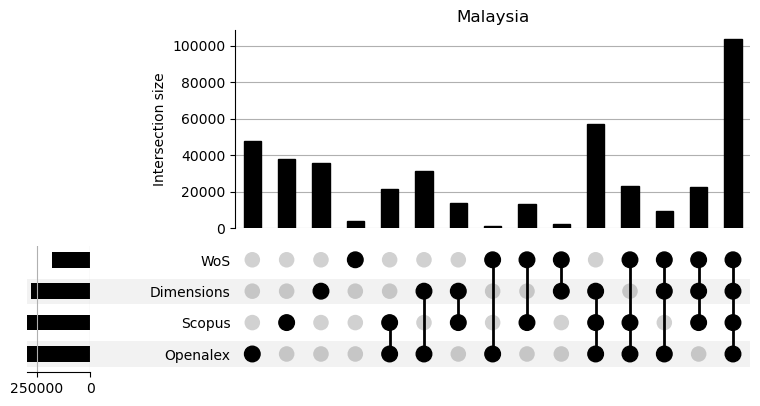

In [124]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[3872,37644,35457,47990,13019,1148,2203,21732,31254,13757,23174,9660,57179,22762,103397]
)

plot(df)
plt.title('Malaysia
plt.show() 

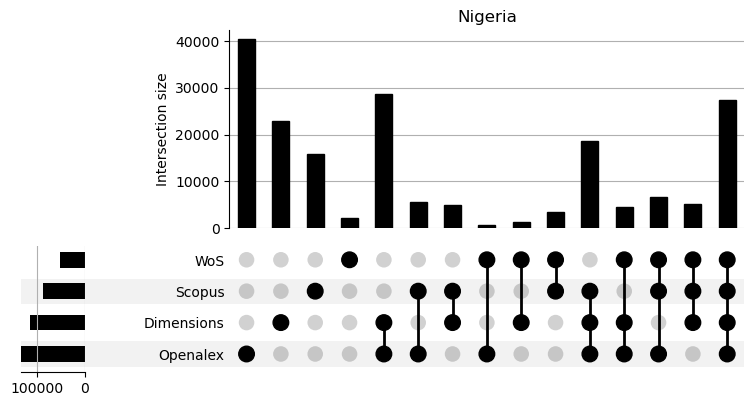

In [125]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[2209,15744,22852,40299,3529,645,1238,5555,28763,4936,6639,4443,18598,5137,27410]
)

plot(df)
plt.title('Nigeria')
plt.show() 

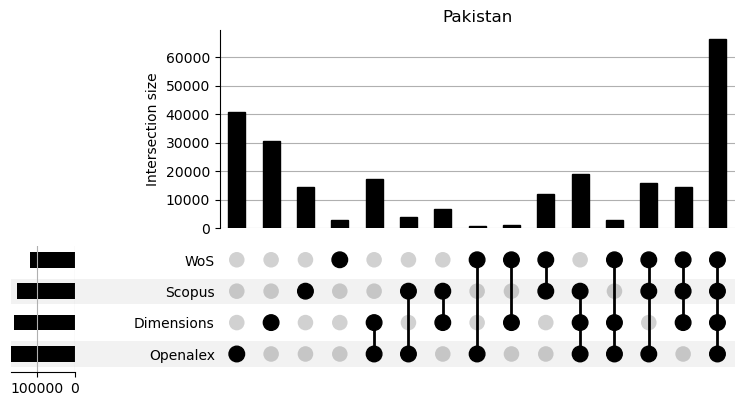

In [126]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[2970,14349,30523,40605,11985,607,1281,3836,17231,6664,15808,2788,19063,14510,66156]
)

plot(df)
plt.title('Pakistan')
plt.show() 

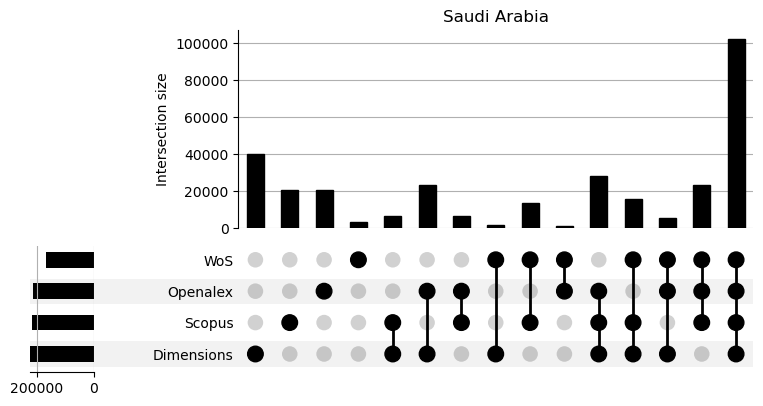

In [127]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[3597,20811,40156,20713,13638,1139,1751,6757,23358,6745,23617,5359,28117,15983,102047]

plot(df)
plt.title('Saudi Arabia')
plt.show() 

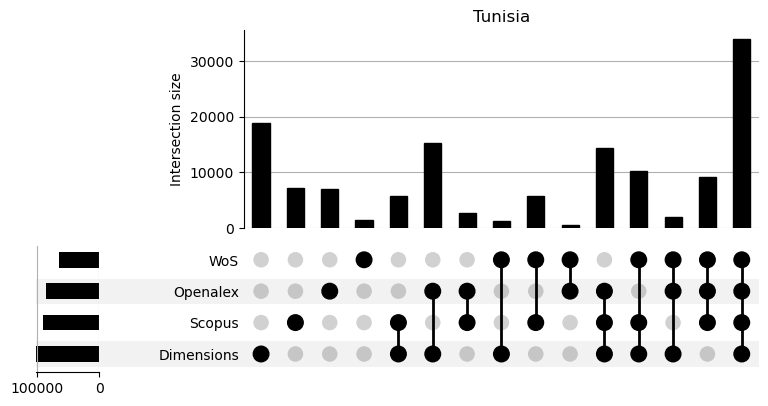

In [128]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[1518,7233,18909,6994,5819,516,1198,2710,15255,5855,9245,1978,14404,10231,33817]
)

plot(df)
plt.title('Tunisia')
plt.show() 

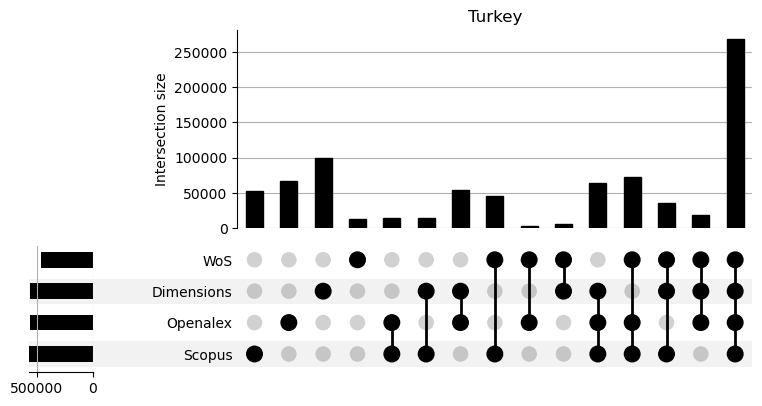

In [129]:
from upsetplot import from_memberships
df = from_memberships(
    [['WoS'],
    ['Scopus'],
    ['Dimensions'],
    ['Openalex'],
    ['WoS', 'Scopus'],
    ['WoS', 'Openalex'],
    ['WoS', 'Dimensions'],
    ['Scopus', 'Openalex'],
    ['Dimensions', 'Openalex'],
    ['Dimensions', 'Scopus'],
    ['WoS', 'Scopus', 'Openalex'],
    ['Dimensions', 'Openalex', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus'],
    ['Dimensions', 'Scopus', 'WoS'],
    ['Dimensions', 'Openalex', 'Scopus', 'WoS']    
     ],
     data=[13723,52650,99169,67410,45730,3402,5590,15143,53611,14951,72908,18558,63363,35652,267480]
)

plot(df)
plt.title('Turkey'
plt.show() 

In [54]:
df_i=pd.read_excel(r"D:\10 COUNTRIES COMPARE\institutions per database.xlsx")

In [55]:
df_i.nunique()

Institution        20
WoS Rank           20
Scopus Rank        18
Dimensions Rank    16
OpenAlex Rank      16
dtype: int64

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [56]:
institutions = df_i['Institution']
wos_ranks = df_i['WoS Rank']
scopus_ranks = df_i['Scopus Rank']
dimensions_ranks = df_i['Dimensions Rank']
openalex_ranks = df_i['OpenAlex Rank']


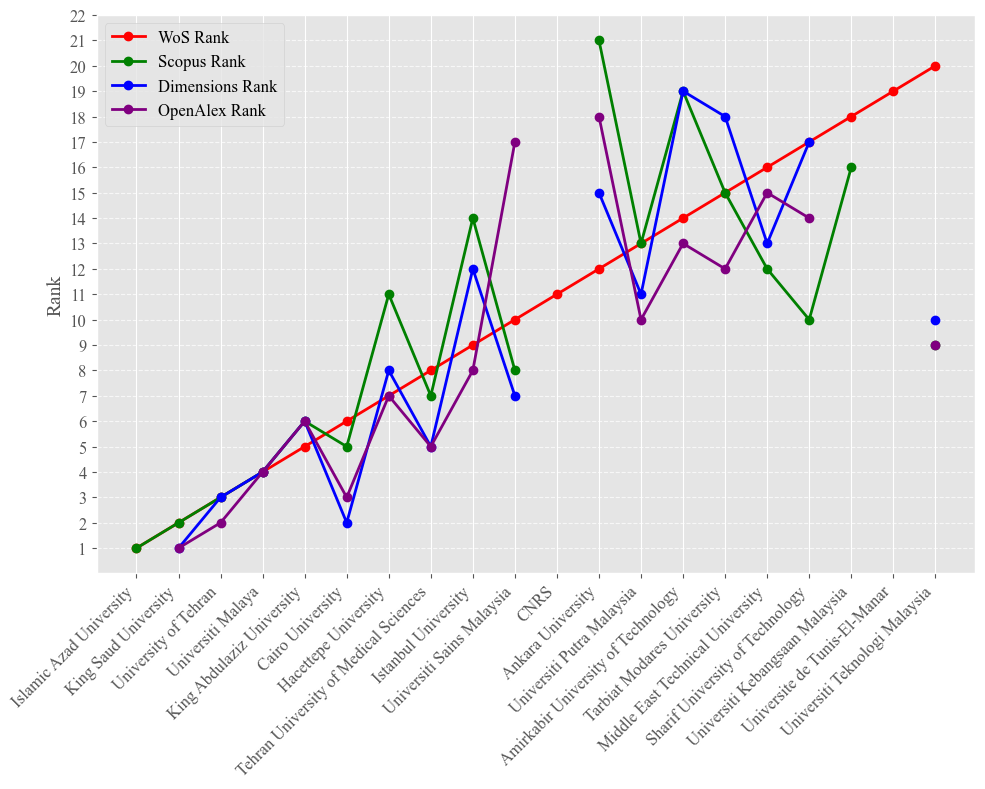

In [64]:

plt.figure(figsize=(10, 8))

plt.plot(wos_ranks, label='WoS Rank', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(scopus_ranks, label='Scopus Rank', marker='o', linestyle='-', color='green', linewidth=2)
plt.plot(dimensions_ranks, label='Dimensions Rank', marker='o', linestyle='-', color='blue', linewidth=2)
plt.plot(openalex_ranks, label='OpenAlex Rank', marker='o', linestyle='-', color='purple', linewidth=2)

plt.xticks(range(len(institutions)), institutions, rotation=45, ha='right', fontsize=12, fontname='Times New Roman')
plt.yticks(range(1, 23), fontsize=12, fontname='Times New Roman')
#plt.xlabel('Institution', fontsize=14, fontname='Times New Roman')
plt.ylabel('Rank', fontsize=14, fontname='Times New Roman')
#plt.title('Slope Chart: Rank Changes Across Databases', fontsize=16, fontname='Times New Roman')
legend = plt.legend(prop={'family': 'Times New Roman', 'size': 12})
for text in legend.get_texts():
    text.set_color('black')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


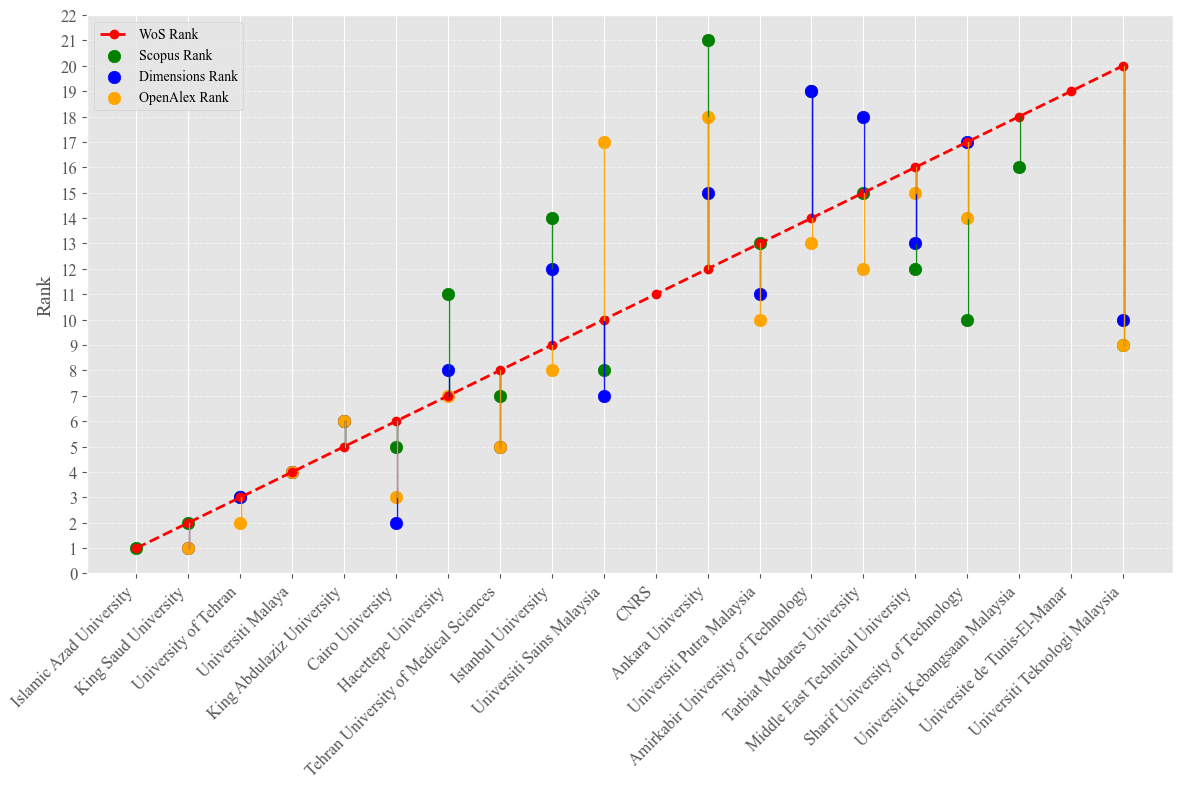

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample dataset
data = {
    'Institution': [
        'Islamic Azad University', 'King Saud University', 'University of Tehran', 'Universiti Malaya',
        'King Abdulaziz University', 'Cairo University', 'Hacettepe University',
        'Tehran University of Medical Sciences', 'Istanbul University', 'Universiti Sains Malaysia',
        'CNRS', 'Ankara University', 'Universiti Putra Malaysia',
        'Amirkabir University of Technology', 'Tarbiat Modares University',
        'Middle East Technical University', 'Sharif University of Technology',
        'Universiti Kebangsaan Malaysia', 'Universite de Tunis-El-Manar',
        'Universiti Teknologi Malaysia'
    ],
    'WoS Rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'Scopus Rank': [1, 2, 3, 4, 6, 5, 11, 7, 14, 8, np.nan, 21, 13, 19, 15, 12, 10, 16, np.nan, 9],
    'Dimensions Rank': [np.nan, 1, 3, 4, 6, 2, 8, 5, 12, 7, np.nan, 15, 11, 19, 18, 13, 17, np.nan, np.nan, 10],
    'OpenAlex Rank': [np.nan, 1, 2, 4, 6, 3, 7, 5, 8, 17, np.nan, 18, 10, 13, 12, 15, 14, np.nan, np.nan, 9]
}

df = df_i
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df['Institution'], df['WoS Rank'], label='WoS Rank', marker='o', color='red', linewidth=2, linestyle = '--')

rank_colors = {'Scopus Rank': 'green', 'Dimensions Rank': 'blue', 'OpenAlex Rank': 'orange'}
for column, color in rank_colors.items():
    ax.scatter(df['Institution'], df[column], label=column, s=80, color=color)

plt.xticks(rotation=45, ha='right', fontsize=12, fontname='Times New Roman')
plt.yticks(range(0, 23), fontsize=12, fontname='Times New Roman')
plt.ylim(0, 22)  
plt.ylabel('Rank', fontsize=14, fontname='Times New Roman')
#plt.title('Rank Changes Across Databases', fontsize=16, fontname='Times New Roman')

ax.legend(fontsize=12, prop={'family': 'Times New Roman'})

for i, institution in enumerate(df['Institution']):
    for column, line_color in rank_colors.items():
        rank = df[column].iloc[i]
        if not np.isnan(rank):
            x_val = i + 0.01  
            
            
            ax.plot([x_val, x_val], [rank, df['WoS Rank'].iloc[i]], color=line_color, alpha=0.9, linewidth=1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


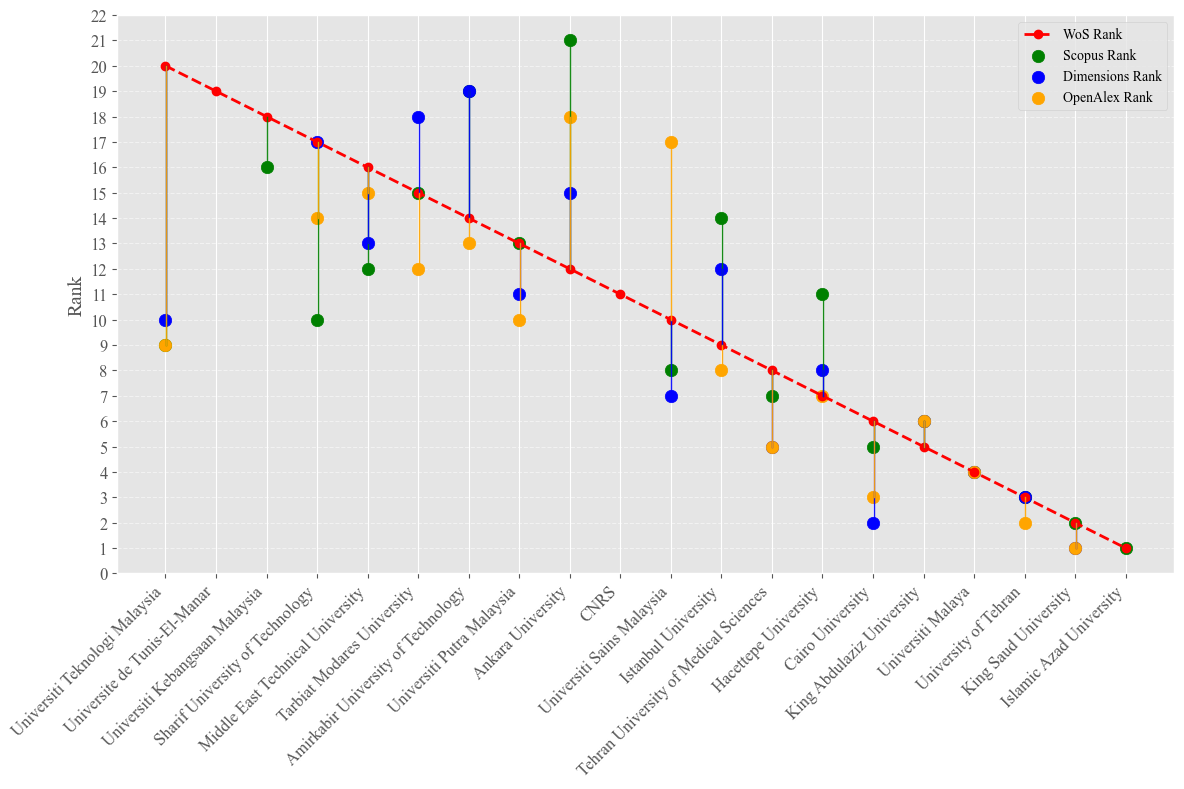

In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'Institution': [
        'Islamic Azad University', 'King Saud University', 'University of Tehran', 'Universiti Malaya',
        'King Abdulaziz University', 'Cairo University', 'Hacettepe University',
        'Tehran University of Medical Sciences', 'Istanbul University', 'Universiti Sains Malaysia',
        'CNRS', 'Ankara University', 'Universiti Putra Malaysia',
        'Amirkabir University of Technology', 'Tarbiat Modares University',
        'Middle East Technical University', 'Sharif University of Technology',
        'Universiti Kebangsaan Malaysia', 'Universite de Tunis-El-Manar',
        'Universiti Teknologi Malaysia'
    ],
    'WoS Rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'Scopus Rank': [1, 2, 3, 4, 6, 5, 11, 7, 14, 8, np.nan, 21, 13, 19, 15, 12, 10, 16, np.nan, 9],
    'Dimensions Rank': [np.nan, 1, 3, 4, 6, 2, 8, 5, 12, 7, np.nan, 15, 11, 19, 18, 13, 17, np.nan, np.nan, 10],
    'OpenAlex Rank': [np.nan, 1, 2, 4, 6, 3, 7, 5, 8, 17, np.nan, 18, 10, 13, 12, 15, 14, np.nan, np.nan, 9]
}

df = pd.DataFrame(data)
df = df[::-1].reset_index(drop=True)


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df['Institution'], df['WoS Rank'], label='WoS Rank', marker='o', color='red', linewidth=2, linestyle = '--')

rank_colors = {'Scopus Rank': 'green', 'Dimensions Rank': 'blue', 'OpenAlex Rank': 'orange'}
for column, color in rank_colors.items():
    ax.scatter(df['Institution'], df[column], label=column, s=80, color=color)

plt.xticks(rotation=45, ha='right', fontsize=12, fontname='Times New Roman')
plt.yticks(range(0, 23), fontsize=12, fontname='Times New Roman')
plt.ylim(0, 22)  
plt.ylabel('Rank', fontsize=14, fontname='Times New Roman')
#plt.title('Rank Changes Across Databases', fontsize=16, fontname='Times New Roman')

ax.legend(fontsize=12, prop={'family': 'Times New Roman'})

for i, institution in enumerate(df['Institution']):
    for column, line_color in rank_colors.items():
        rank = df[column].iloc[i]
        if not np.isnan(rank):
            
            x_val = i + 0.01  
            ax.plot([x_val, x_val], [rank, df['WoS Rank'].iloc[i]], color=line_color, alpha=0.9, linewidth=1)

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text  

In [5]:
df = pd.read_excel(r"D:\10 COUNTRIES COMPARE\root-concepts-frequency.xlsx", sheet_name= 'Sheet3')
df.head()

,Concept,WoS-OpenAlex joint coverage,OpenAlex-only coverage
0,Medicine,612610,580196
1,Chemistry,568329,270210
2,Biology,513723,431732
3,Physics,458098,334126
4,Materials science,437220,166187


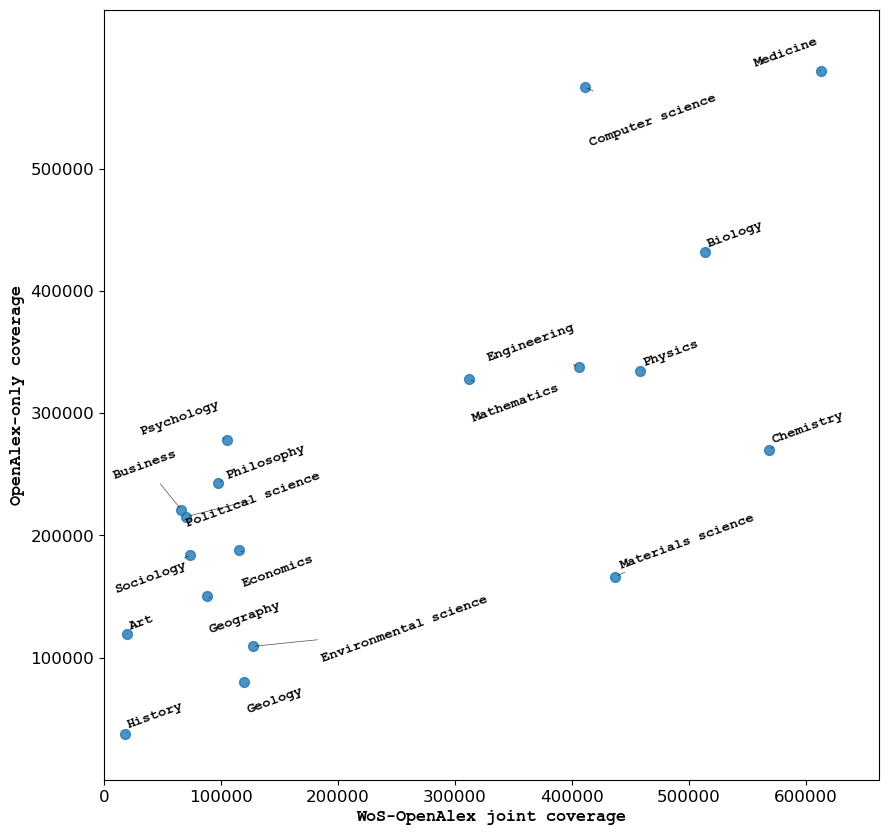

In [6]:

font_path = fm.findSystemFonts(fontpaths=None, fontext='ttf')[0] 
font_prop = fm.FontProperties(fname=font_path, size=12)

fig = plt.figure(figsize=(10, 10))
scatter_plot = sns.regplot(x="WoS-OpenAlex joint coverage", y="OpenAlex-only coverage", data=df, scatter_kws={"s": 50}, fit_reg=False)

concept_data = df['Concept']
x = df['WoS-OpenAlex joint coverage']
y = df['OpenAlex-only coverage']

label_objs = []

label_offset = 0.01  

for i, concept in enumerate(concept_data):
    x_pos = x[i] + label_offset
    y_pos = y[i] + label_offset

    label_obj = plt.text(x_pos, y_pos, concept, fontproperties=font_prop, rotation=20, fontsize=10)
    label_objs.append(label_obj)

adjust_text(label_objs, arrowprops=dict(arrowstyle="-", lw=0.5, alpha=0.7), force_points=(0.2, 0.2))

plt.xlabel("WoS-OpenAlex joint coverage", fontproperties=font_prop)
plt.ylabel("OpenAlex-only coverage", fontproperties=font_prop)

plt.xticks(range(0, int(max(x)) + 1, 100000), rotation=0, fontsize=12)
plt.yticks(range(0, int(max(y)) + 1, 100000), fontsize=12)

plt.xlim(0, int(max(x)) + 50000)
plt.ylim(1, int(max(y)) + 50000)
plt.savefig("scatter_plot.png", dpi=300, bbox_inches="tight")

plt.show()
